# Preliminary data exploration for the Lending Club data set

This workbook is for me to familiarize myself with the data we have

In [2]:
# standard headers copied from HW 4
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

In [3]:
# Andrew's additional top-level setup
plt.style.use('ggplot')  # looks better and is more informative
from collections import namedtuple  # makes returning complex values less error-prone

In [4]:
# Read in the raw data taken from TODO put url here
raw_lc_data = pd.read_csv('data/loan.csv',
                         )

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


TODO: We got the following warning:

```C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
```

so we'll have to pay particular attention to columns 19 and 55.

In [5]:
for date_column in [
    'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line'
]:
    print date_column
    raw_lc_data[date_column] = pd.to_datetime(raw_lc_data[date_column],
                                              format='%b-%Y')

issue_d
last_pymnt_d
next_pymnt_d
last_credit_pull_d
earliest_cr_line


In [6]:
print raw_lc_data.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'application_type',
       u'annu

In [8]:
del raw_lc_data['url']  # redundant and messes stuff up

In [ ]:
def good_bad_quantile_plot(data, column):
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    defaults = data['loan_status'] == 'Charged Off'  # for now TODO

    # 45-degree line
    plt.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    plt.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    plt.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    plt.title("QQ plot for " + column)
    plt.xlabel('Good loans')
    plt.ylabel('Bad loans')
    plt.show()

In [45]:
# Let's create a helper function that will explore each column
def explore_column(data, c):
    print '---------------------------'
    col_data = data[c]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    if col_data.dtype == '<M8[ns]':
        col_data = col_data.dt.strftime('%Y-%m')
    defaults = data['loan_status'] == 'Charged Off'  # for now TODO
    
    # Does it have a small number of values?
    vcounts = col_data.value_counts()
    vcounts_default = col_data[defaults].value_counts()[vcounts.index]
    
    print "%s: dtype=%s, %d nulls, count vals=%d" % (
        c, col_data.dtype, sum(nulls), len(vcounts)
    )
    # Is it categorical?
    if len(vcounts) < 20 or col_data.dtype == 'O':
        print "Total number of distinct values: %d" % (len(vcounts), )

        if len(vcounts) > 20:
            # Reduce it to a reasonable number.
            vcounts = vcounts[0:19].append(pd.Series(vcounts[19:].sum(), index=['Others']))
            vcounts_default = vcounts_default[0:19].append(pd.Series(vcounts_default[19:].sum(), index=['Others']))

        vcounts_default.fillna(0, inplace=True)
        vcounts_display = pd.DataFrame(vcounts)
        vcounts_display.columns = ['Total']
        vcounts_display['Good'] = vcounts - vcounts_default
        vcounts_display['Defaults'] = vcounts_default
        vcounts_display['% Defaults'] = 100.0 * vcounts_default / vcounts
        print vcounts_display

        plt.title(c)
        plt.bar(range(len(vcounts)), vcounts, color='b')
        plt.bar(range(len(vcounts)), vcounts_default, color='r')
        plt.gca().set_xticks(np.arange(0.5, 0.5+len(vcounts)))
        plt.gca().set_xticklabels(vcounts.index)
        plt.show()
        return

    try:
        # It must be numeric at this point
        # We want to see Quartiles, 95% interval, min/max
        quantiles_good = col_data[~defaults].quantile(q=[0, 0.025, 0.25, 0.50, 0.75, 0.975, 1.0]).tolist()
        quantiles_defaults = col_data[defaults].quantile(q=[0, 0.025, 0.25, 0.50, 0.75, 0.975, 1.0]).tolist()
        print "     %10s  %10s  %10s  %10s  %10s  %10s  %10s" % (
            'Min', '2.5%', '25%', '50%', '75%', '97.5%', 'Max',
        )
        print "GOOD %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f" % tuple(quantiles_good)
        print "BAD  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f" % tuple(quantiles_defaults)

        fig, axs = plt.subplots(2, 1, sharex=True)

        plt.axes(axs[0])
        plt.title(c + " - Good")
        plt.hist(col_data[~defaults], bins=40, color='b')
        plt.axvline(x=col_data[~defaults].mean(), color='k')
        plt.xlim(col_data.min(), col_data.max())
        for q in quantiles_good:
            plt.axvline(x=q, color='b')

        plt.axes(axs[1])
        plt.title(c + " - Bad")
        plt.hist(col_data[defaults], bins=40, color='r')
        plt.axvline(x=col_data[defaults].mean(), color='k')
        plt.xlim(col_data.min(), col_data.max())
        for q in quantiles_defaults:
            plt.axvline(x=q, color='r')
        plt.show()
        
        good_bad_quantile_plot(data, c)

    except Exception as e:
        print e
        raise

## Unit test the exploration function

---------------------------
loan_status: dtype=object, 0 nulls, count vals=10
Total number of distinct values: 10
                                                     Total      Good  \
Current                                             601779  601779.0   
Fully Paid                                          207723  207723.0   
Charged Off                                          45248       0.0   
Late (31-120 days)                                   11591   11591.0   
Issued                                                8460    8460.0   
In Grace Period                                       6253    6253.0   
Late (16-30 days)                                     2357    2357.0   
Does not meet the credit policy. Status:Fully Paid    1988    1988.0   
Default                                               1219    1219.0   
Does not meet the credit policy. Status:Charged...     761     761.0   

                                                    Defaults  % Defaults  
Current           

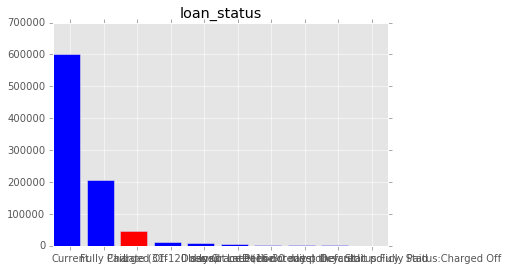

In [11]:
explore_column(raw_lc_data, 'loan_status')

---------------------------
sub_grade: dtype=object, 0 nulls, count vals=35
Total number of distinct values: 35
         Total    Good  Defaults  % Defaults
B3       56323   54064      2259    4.010795
B4       55626   53303      2323    4.176105
C1       53387   50904      2483    4.650945
C2       52236   49705      2531    4.845317
C3       50161   47610      2551    5.085624
C4       48857   46293      2564    5.247969
B5       48833   46702      2131    4.363852
B2       48781   47188      1593    3.265616
B1       44972   43759      1213    2.697234
A5       44816   43835       981    2.188950
C5       41219   38706      2513    6.096703
D1       36238   33870      2368    6.534577
A4       34531   33752       779    2.255944
D2       29803   27533      2270    7.616683
D3       26554   24514      2040    7.682458
D4       25558   23473      2085    8.157915
A3       23457   23058       399    1.700985
A1       22913   22732       181    0.789945
A2       22485   22208       277 

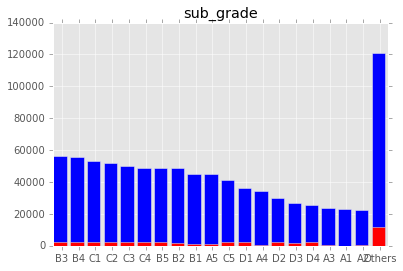

In [12]:
explore_column(raw_lc_data, 'sub_grade')

---------------------------
mths_since_last_record: dtype=float64, 750326 nulls, count vals=123
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       12.00       51.00       69.00       91.00      117.00      121.00
BAD        0.00        8.00       58.00       86.00      103.00      117.00      129.00


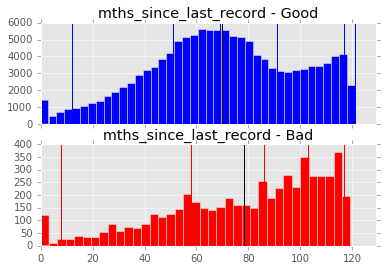

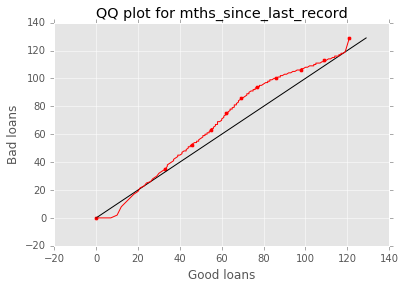

In [46]:
explore_column(raw_lc_data, 'mths_since_last_record')

In [47]:
# We need to restrict our investigations to loans whose status is known
# We can look at the status values above
lc_data = raw_lc_data[raw_lc_data.loan_status.isin(['Fully Paid', 'Charged Off'])]

## Explore the data
Now that we have tested our exploration function, let's iterate over all the columns

---------------------------
id: dtype=int64, 0 nulls, count vals=252971
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   54734.00   461199.35  1439717.00  6225193.00  17212845.50  55111138.60  68604659.00
BAD    57167.00   500326.15  1568881.75  6581844.00  15021673.00  42505257.97  60516983.00


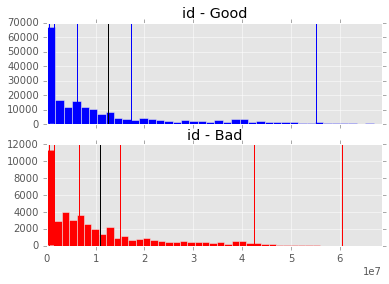

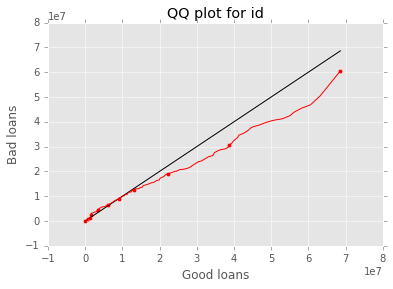

---------------------------
member_id: dtype=int64, 0 nulls, count vals=252971
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   70699.00   573741.65  1684432.50  7450306.00  19225968.00  58681050.05  73507418.00
BAD    80353.00   641491.88  1824480.25  8047168.00  16742592.75  45472061.12  64537751.00


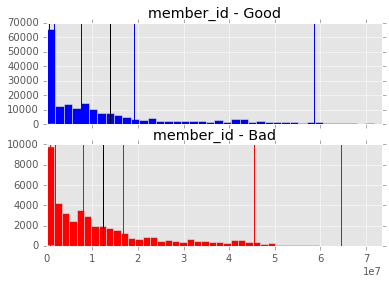

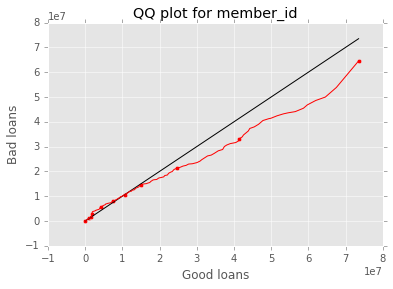

---------------------------
loan_amnt: dtype=float64, 0 nulls, count vals=1326
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2225.00     7200.00    12000.00    18000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12675.00    20000.00    35000.00    35000.00


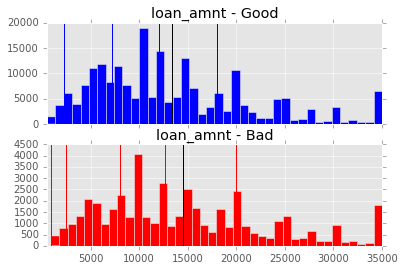

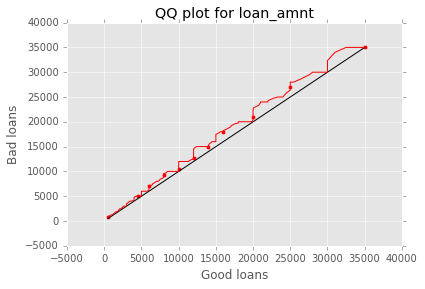

---------------------------
funded_amnt: dtype=float64, 0 nulls, count vals=1326
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2200.00     7150.00    12000.00    18000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12600.00    20000.00    35000.00    35000.00


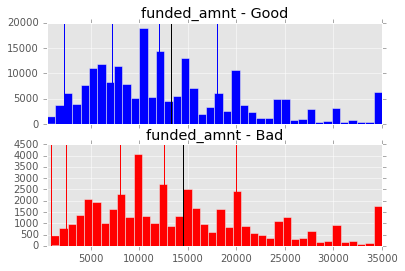

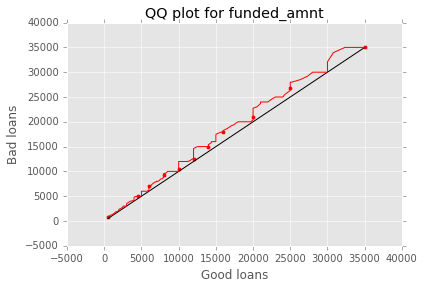

---------------------------
funded_amnt_inv: dtype=float64, 0 nulls, count vals=8527
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2000.00     7000.00    11725.00    18000.00    34975.00    35000.00
BAD        0.00     2400.00     8000.00    12375.00    19975.00    35000.00    35000.00


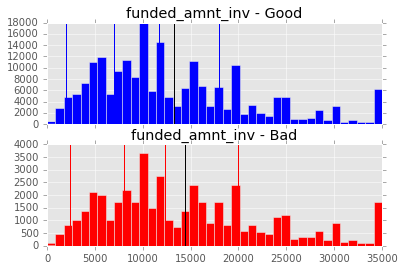

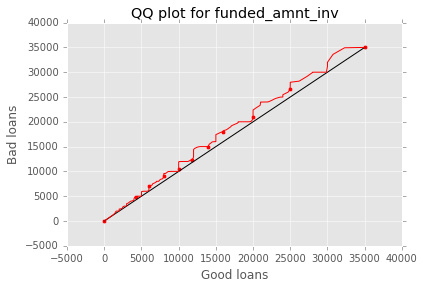

---------------------------
term: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
             Total    Good  Defaults  % Defaults
 36 months  196658  167575     29083   14.788618
 60 months   56313   40148     16165   28.705627


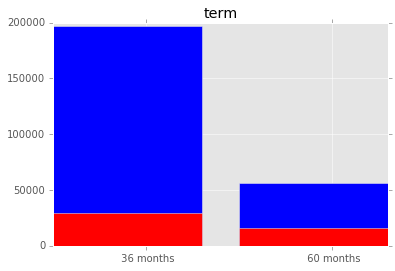

---------------------------
int_rate: dtype=float64, 0 nulls, count vals=513
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       5.32        6.03       10.16       13.11       15.81       22.95       28.99
BAD        5.42        7.88       13.05       15.80       18.92       24.83       28.99


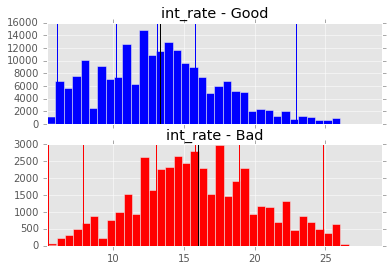

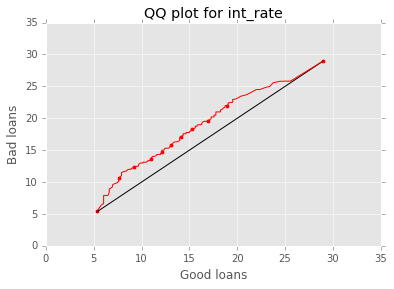

---------------------------
installment: dtype=float64, 0 nulls, count vals=45487
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD      15.69       74.08      234.36      360.08      540.56     1029.71     1409.99
BAD       21.62       85.62      265.18      390.83      573.32     1033.01     1424.57


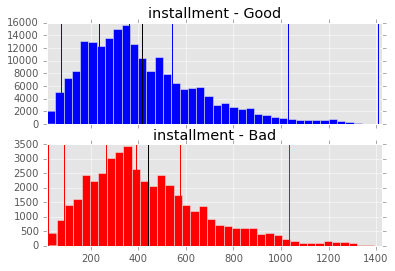

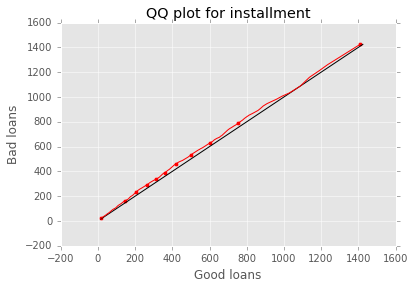

---------------------------
grade: dtype=object, 0 nulls, count vals=7
Total number of distinct values: 7
   Total   Good  Defaults  % Defaults
B  76065  66546      9519   12.514297
C  65320  52678     12642   19.353950
A  42296  39679      2617    6.187346
D  40506  30020     10486   25.887523
E  19186  12928      6258   32.617534
F   7660   4726      2934   38.302872
G   1938   1146       792   40.866873


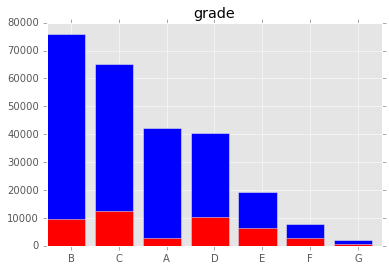

---------------------------
sub_grade: dtype=object, 0 nulls, count vals=35
Total number of distinct values: 35
        Total   Good  Defaults  % Defaults
B3      18068  15809      2259   12.502767
B4      16933  14610      2323   13.718774
C1      14959  12476      2483   16.598703
B2      14628  13035      1593   10.890074
C2      14341  11810      2531   17.648700
B5      14340  12209      2131   14.860530
C3      12778  10227      2551   19.964001
B1      12096  10883      1213   10.028108
C4      12056   9492      2564   21.267419
A5      11993  11012       981    8.179772
C5      11186   8673      2513   22.465582
A4      11058  10279       779    7.044674
D1      10046   7678      2368   23.571571
D2       9051   6781      2270   25.080102
D3       7991   5951      2040   25.528720
D4       7384   5299      2085   28.236728
A3       7173   6774       399    5.562526
A2       6202   5925       277    4.466301
D5       6034   4311      1723   28.554856
Others  34654  24489     101

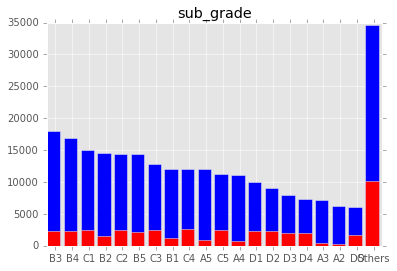

---------------------------
emp_title: dtype=object, 13928 nulls, count vals=132762
Total number of distinct values: 132762
                   Total      Good  Defaults  % Defaults
Manager             1941    1560.0     381.0   19.629057
Teacher             1909    1594.0     315.0   16.500786
Supervisor           852     686.0     166.0   19.483568
Registered Nurse     841     689.0     152.0   18.073722
RN                   841     698.0     143.0   17.003567
Sales                677     538.0     139.0   20.531758
Project Manager      669     582.0      87.0   13.004484
manager              579     418.0     161.0   27.806563
Office Manager       568     488.0      80.0   14.084507
Driver               534     394.0     140.0   26.217228
Director             501     438.0      63.0   12.574850
Engineer             470     411.0      59.0   12.553191
Owner                459     348.0     111.0   24.183007
US Army              457     377.0      80.0   17.505470
General Manager      

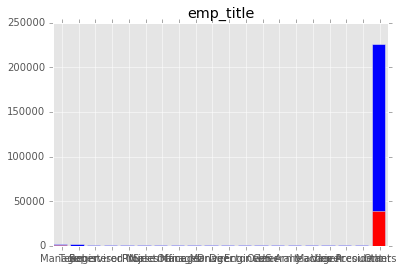

---------------------------
emp_length: dtype=object, 0 nulls, count vals=12
Total number of distinct values: 12
           Total   Good  Defaults  % Defaults
10+ years  76881  63748     13133   17.082244
2 years    23561  19528      4033   17.117270
< 1 year   20886  17033      3853   18.447764
3 years    20380  16846      3534   17.340530
5 years    18059  14856      3203   17.736309
1 year     16856  13892      2964   17.584243
4 years    16197  13422      2775   17.132802
6 years    14753  12058      2695   18.267471
7 years    14085  11483      2602   18.473553
8 years    11849   9695      2154   18.178749
n/a         9897   7372      2525   25.512782
9 years     9567   7790      1777   18.574266


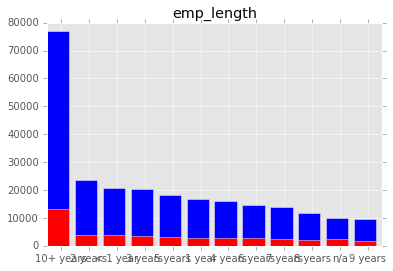

---------------------------
home_ownership: dtype=object, 0 nulls, count vals=6
Total number of distinct values: 6
           Total      Good  Defaults  % Defaults
MORTGAGE  124844  104966.0   19878.0   15.922271
RENT      105957   84646.0   21311.0   20.112876
OWN        21985   17960.0    4025.0   18.307937
OTHER        141     114.0      27.0   19.148936
NONE          43      36.0       7.0   16.279070
ANY            1       1.0       0.0    0.000000


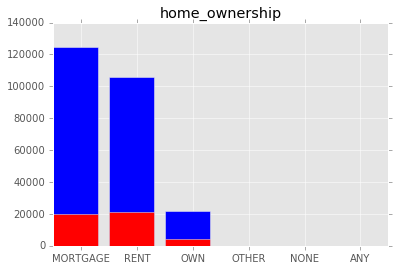

---------------------------
annual_inc: dtype=float64, 0 nulls, count vals=19483
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD    3000.00    24000.00    45000.00    64162.00    90000.00   180000.00  7141778.00
BAD     4080.00    21180.70    40000.00    56000.00    78000.00   160000.00  8706582.00


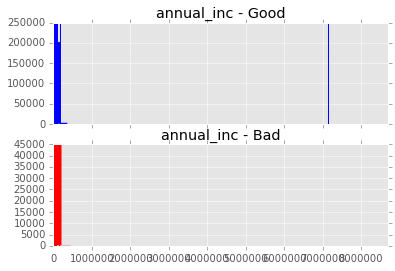

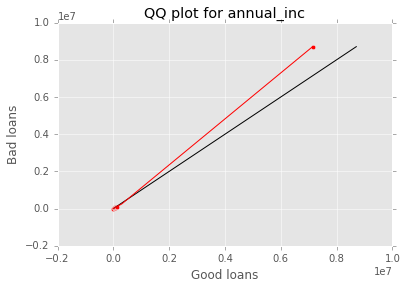

---------------------------
verification_status: dtype=object, 0 nulls, count vals=3
Total number of distinct values: 3
                 Total   Good  Defaults  % Defaults
Verified         92896  73596     19300   20.775921
Not Verified     86064  73856     12208   14.184793
Source Verified  74011  60271     13740   18.564808


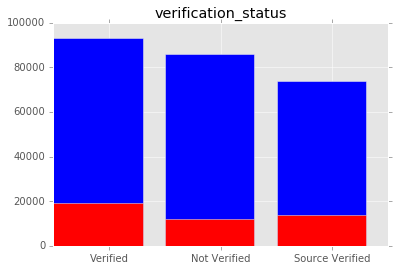

---------------------------
issue_d: dtype=object, 0 nulls, count vals=103
Total number of distinct values: 103
          Total      Good  Defaults  % Defaults
2014-10    8727    7005.0    1722.0   19.731867
2014-07    8527    6773.0    1754.0   20.569954
2014-04    6702    5266.0    1436.0   21.426440
2013-11    6642    5287.0    1355.0   20.400482
2013-10    6636    5264.0    1372.0   20.675105
2013-12    6623    5345.0    1278.0   19.296391
2014-01    6489    5214.0    1275.0   19.648636
2013-08    6401    5030.0    1371.0   21.418528
2014-05    6391    5048.0    1343.0   21.013926
2013-09    6350    5007.0    1343.0   21.149606
2013-07    6159    4800.0    1359.0   22.065270
2014-03    6141    4875.0    1266.0   20.615535
2013-06    6016    4674.0    1342.0   22.307181
2013-05    5876    4560.0    1316.0   22.396188
2014-02    5864    4598.0    1266.0   21.589359
2012-11    5863    4932.0     931.0   15.879243
2012-10    5835    4946.0     889.0   15.235647
2012-09    5688    4798.

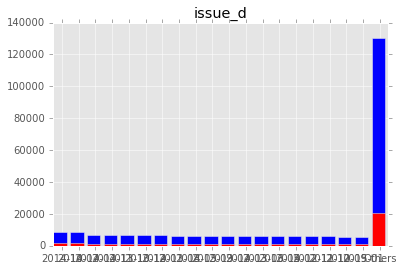

---------------------------
loan_status: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
              Total      Good  Defaults  % Defaults
Fully Paid   207723  207723.0       0.0         0.0
Charged Off   45248       0.0   45248.0       100.0


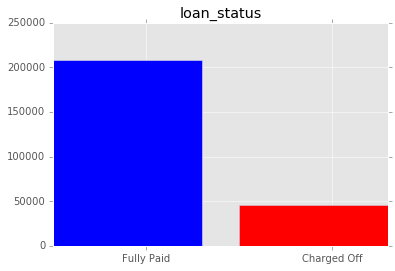

---------------------------
pymnt_plan: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
    Total      Good  Defaults  % Defaults
n  252969  207721.0   45248.0   17.886777
y       2       2.0       0.0    0.000000


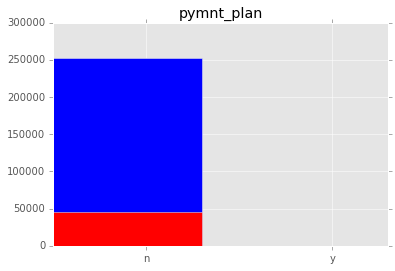

---------------------------
desc: dtype=object, 164651 nulls, count vals=87640
Total number of distinct values: 87640
                                                    Total     Good  Defaults  \
                                                      216    188.0      28.0   
Debt Consolidation                                     10      5.0       5.0   
Camping Membership                                      6      5.0       1.0   
  Borrower added on 03/10/14 > Debt consolidati...      6      2.0       4.0   
  Borrower added on 01/03/14 > Debt consolidati...      5      4.0       1.0   
  Borrower added on 12/02/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 11/14/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 12/16/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 02/27/14 > Debt consolidati...      4      3.0       1.0   
  Borrower added on 10/01/12 > Debt consolidati...      4      3.0       1.0   
  

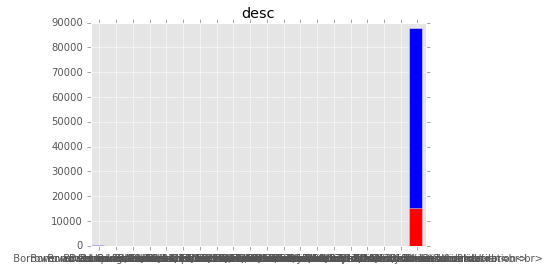

---------------------------
purpose: dtype=object, 0 nulls, count vals=14
Total number of distinct values: 14
                     Total    Good  Defaults  % Defaults
debt_consolidation  148363  120764     27599   18.602347
credit_card          50076   42250      7826   15.628245
home_improvement     14929   12660      2269   15.198607
other                14277   11341      2936   20.564544
major_purchase        6265    5391       874   13.950519
small_business        4746    3375      1371   28.887484
car                   3646    3198       448   12.287438
medical               2854    2285       569   19.936931
moving                2028    1603       425   20.956607
wedding               1955    1690       265   13.554987
house                 1652    1366       286   17.312349
vacation              1588    1318       270   17.002519
educational            325     269        56   17.230769
renewable_energy       267     213        54   20.224719


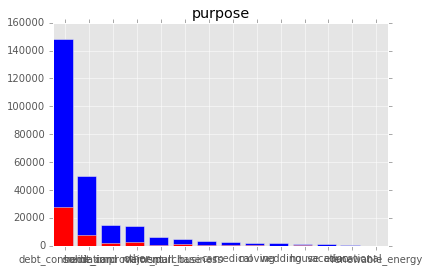

---------------------------
title: dtype=object, 12 nulls, count vals=47929
Total number of distinct values: 47929
                            Total     Good  Defaults  % Defaults
Debt consolidation          72074  58597.0   13477.0   18.698837
Credit card refinancing     22794  19079.0    3715.0   16.298149
Debt Consolidation          11092   9226.0    1866.0   16.822935
Home improvement             6741   5680.0    1061.0   15.739505
Other                        6036   4749.0    1287.0   21.322068
Consolidation                3570   2998.0     572.0   16.022409
debt consolidation           3215   2437.0     778.0   24.199067
Debt Consolidation Loan      3058   2556.0     502.0   16.415958
Major purchase               2158   1811.0     347.0   16.079703
Business                     1743   1224.0     519.0   29.776248
Credit Card Consolidation    1626   1429.0     197.0   12.115621
Personal Loan                1606   1356.0     250.0   15.566625
consolidation                1380   1090

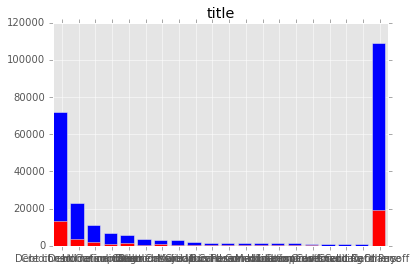

---------------------------
zip_code: dtype=object, 0 nulls, count vals=886
Total number of distinct values: 886
         Total      Good  Defaults  % Defaults
945xx     3286    2784.0     502.0   15.276932
112xx     2832    2281.0     551.0   19.456215
750xx     2767    2333.0     434.0   15.684857
100xx     2522    2165.0     357.0   14.155432
900xx     2474    2054.0     420.0   16.976556
606xx     2449    2097.0     352.0   14.373214
331xx     2286    1795.0     491.0   21.478565
300xx     2279    1919.0     360.0   15.796402
070xx     2192    1786.0     406.0   18.521898
917xx     2080    1678.0     402.0   19.326923
770xx     1964    1667.0     297.0   15.122200
921xx     1959    1614.0     345.0   17.611026
891xx     1950    1493.0     457.0   23.435897
926xx     1874    1551.0     323.0   17.235859
330xx     1847    1459.0     388.0   21.007038
913xx     1672    1383.0     289.0   17.284689
104xx     1669    1298.0     371.0   22.228880
117xx     1646    1324.0     322.0   19.5

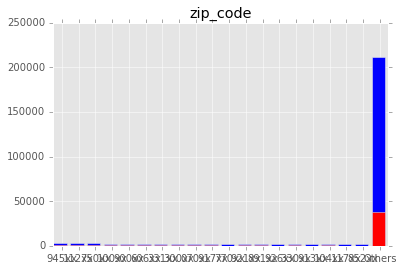

---------------------------
addr_state: dtype=object, 0 nulls, count vals=51
Total number of distinct values: 51
        Total     Good  Defaults  % Defaults
CA      43110  35778.0    7332.0   17.007655
NY      21338  17214.0    4124.0   19.327022
TX      19343  16308.0    3035.0   15.690431
FL      17545  14021.0    3524.0   20.085494
NJ       9601   7760.0    1841.0   19.175086
IL       9253   7711.0    1542.0   16.664865
PA       8399   6842.0    1557.0   18.537921
GA       8014   6654.0    1360.0   16.970302
VA       7942   6504.0    1438.0   18.106270
OH       7738   6266.0    1472.0   19.023003
NC       6919   5613.0    1306.0   18.875560
MA       6139   5122.0    1017.0   16.566216
AZ       6077   5028.0    1049.0   17.261807
MD       6007   4907.0    1100.0   18.311969
MI       5996   4846.0    1150.0   19.179453
WA       5915   4929.0     986.0   16.669484
CO       5613   4829.0     784.0   13.967575
MN       4460   3657.0     803.0   18.004484
MO       3954   3173.0     781.0

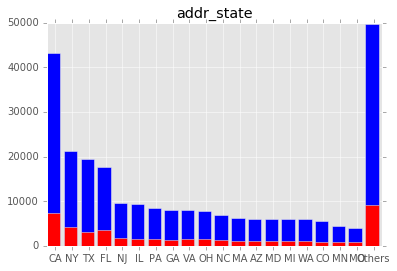

---------------------------
dti: dtype=float64, 0 nulls, count vals=3978
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        2.53       10.42       15.75       21.48       32.02       57.14
BAD        0.00        3.49       12.57       18.35       24.09       33.64       39.98


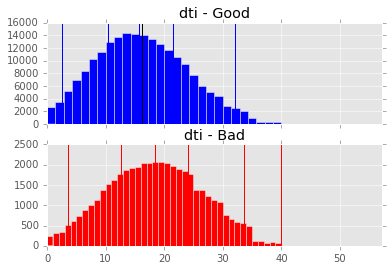

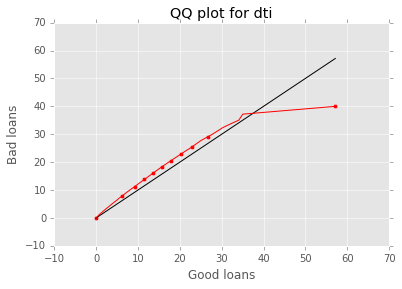

---------------------------
delinq_2yrs: dtype=float64, 0 nulls, count vals=22
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        2.00       29.00
BAD        0.00        0.00        0.00        0.00        0.00        2.00       18.00


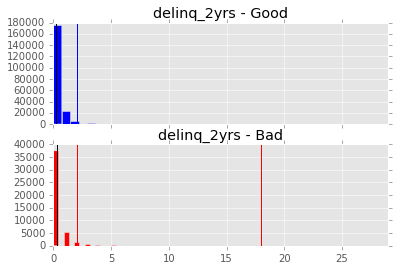

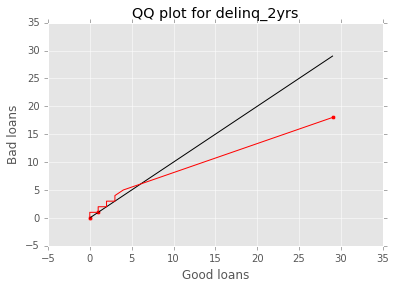

---------------------------
earliest_cr_line: dtype=object, 0 nulls, count vals=644
Total number of distinct values: 644
          Total      Good  Defaults  % Defaults
2000-10    2112    1747.0     365.0   17.282197
1999-10    1965    1673.0     292.0   14.860051
2001-10    1958    1640.0     318.0   16.241062
2000-11    1925    1590.0     335.0   17.402597
2000-08    1922    1570.0     352.0   18.314256
1999-11    1890    1566.0     324.0   17.142857
2001-08    1798    1486.0     312.0   17.352614
2000-12    1763    1432.0     331.0   18.774816
2000-09    1763    1472.0     291.0   16.505956
2001-09    1725    1451.0     274.0   15.884058
2002-10    1716    1429.0     287.0   16.724942
1998-12    1711    1404.0     307.0   17.942724
1999-12    1698    1389.0     309.0   18.197880
1999-08    1665    1348.0     317.0   19.039039
2001-01    1643    1342.0     301.0   18.320146
1999-09    1643    1339.0     304.0   18.502739
2002-09    1639    1356.0     283.0   17.266626
1998-11    1633

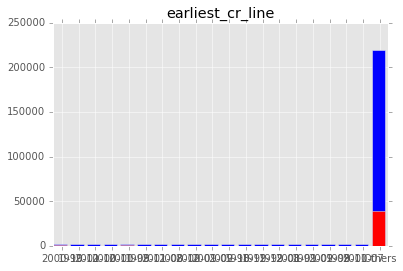

---------------------------
inq_last_6mths: dtype=float64, 0 nulls, count vals=9
Total number of distinct values: 9
      Total    Good  Defaults  % Defaults
0.0  123762  104123     19639   15.868360
1.0   72735   59208     13527   18.597649
2.0   34768   27611      7157   20.585021
3.0   16059   12400      3659   22.784731
4.0    3692    2878       814   22.047671
5.0    1374    1075       299   21.761281
6.0     517     380       137   26.499033
7.0      46      34        12   26.086957
8.0      18      14         4   22.222222


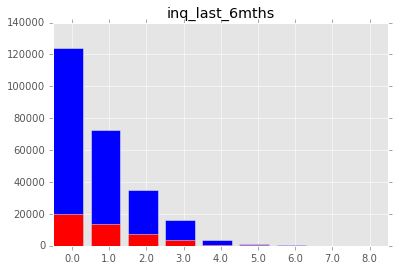

---------------------------
mths_since_last_delinq: dtype=float64, 140820 nulls, count vals=127
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        3.00       17.00       33.00       51.00       78.00      151.00
BAD        0.00        3.00       15.00       31.00       50.00       78.00      152.00


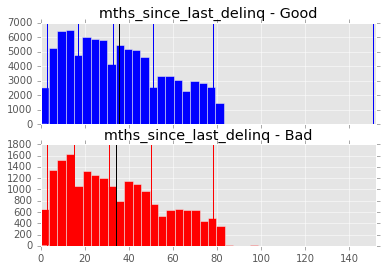

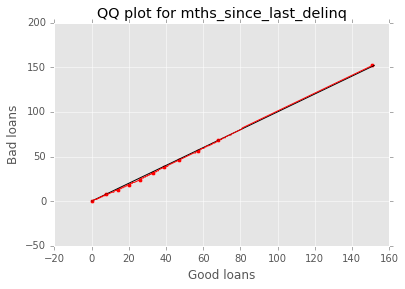

---------------------------
mths_since_last_record: dtype=float64, 221373 nulls, count vals=123
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        7.00       54.00       77.00      101.00      117.00      121.00
BAD        0.00        8.00       58.00       86.00      103.00      117.00      129.00


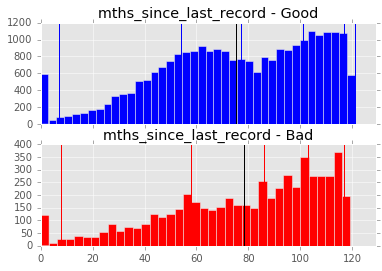

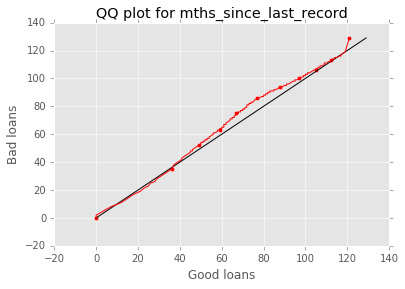

---------------------------
open_acc: dtype=float64, 0 nulls, count vals=59
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        4.00        7.00       10.00       13.00       23.00       58.00
BAD        0.00        4.00        8.00       10.00       14.00       23.00       76.00


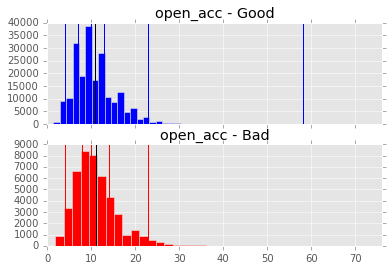

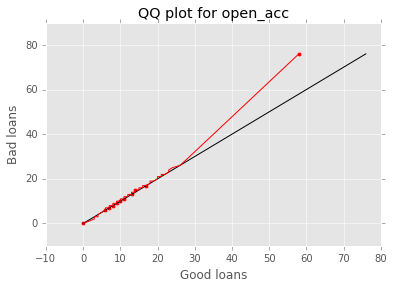

---------------------------
pub_rec: dtype=float64, 0 nulls, count vals=14
Total number of distinct values: 14
       Total      Good  Defaults  % Defaults
0.0   222043  182315.0   39728.0   17.892030
1.0    27332   22494.0    4838.0   17.700863
2.0     2547    2064.0     483.0   18.963486
3.0      676     563.0     113.0   16.715976
4.0      202     158.0      44.0   21.782178
5.0       92      67.0      25.0   27.173913
6.0       39      30.0       9.0   23.076923
7.0       19      14.0       5.0   26.315789
8.0        8       8.0       0.0    0.000000
10.0       5       5.0       0.0    0.000000
9.0        5       3.0       2.0   40.000000
15.0       1       1.0       0.0    0.000000
12.0       1       0.0       1.0  100.000000
11.0       1       1.0       0.0    0.000000


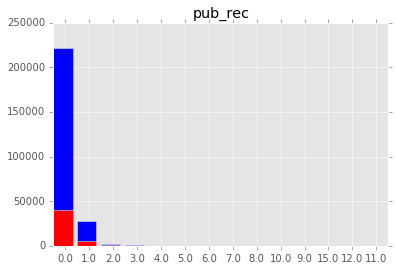

---------------------------
revol_bal: dtype=float64, 0 nulls, count vals=47316
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00      600.00     5786.00    10848.00    19041.00    52239.85  1743266.00
BAD        0.00      770.00     6226.75    11351.50    19204.00    47578.12  1746716.00


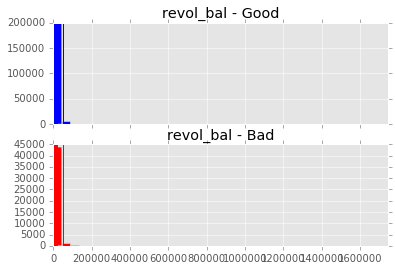

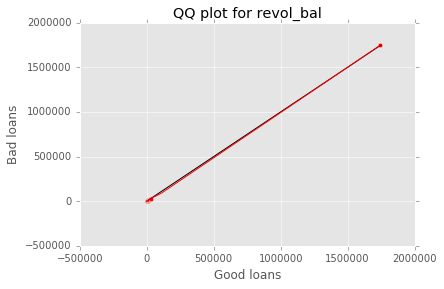

---------------------------
revol_util: dtype=float64, 199 nulls, count vals=1199
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        4.10       34.90       54.50       72.80       95.10      892.30
BAD        0.00        8.50       43.30       61.60       78.00       96.50      129.40


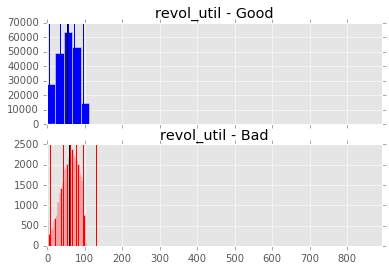

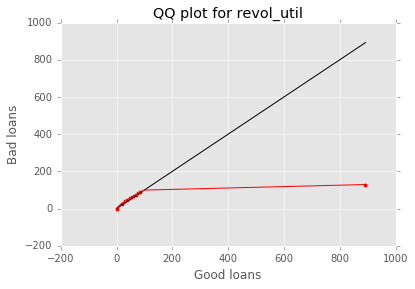

---------------------------
total_acc: dtype=float64, 0 nulls, count vals=105
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       2.00        7.00       17.00       24.00       32.00       53.00      150.00
BAD        2.00        7.00       16.00       23.00       31.00       51.00      110.00


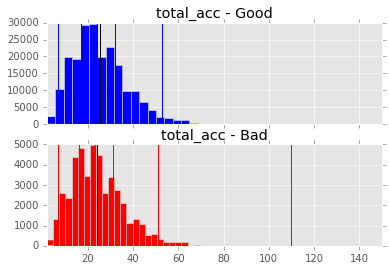

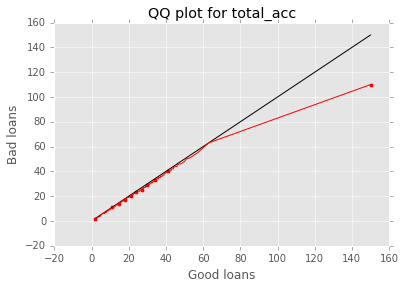

---------------------------
initial_list_status: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
    Total    Good  Defaults  % Defaults
f  182079  149146     32933   18.087204
w   70892   58577     12315   17.371495


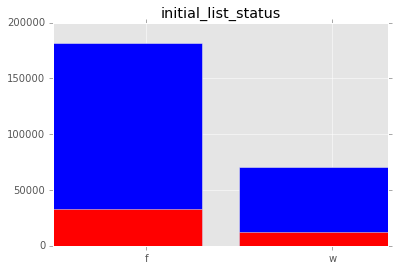

---------------------------
out_prncp: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
0.0  252971  207723     45248   17.886635


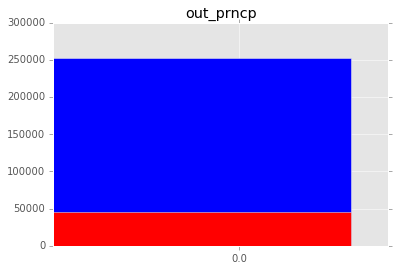

---------------------------
out_prncp_inv: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
0.0  252971  207723     45248   17.886635


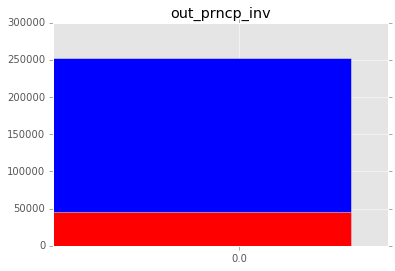

---------------------------
total_pymnt: dtype=float64, 0 nulls, count vals=242391
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2489.47     8056.40    12963.17    20538.34    38874.17    57777.58
BAD        0.00      459.07     2502.76     4873.24     8624.95    20765.46    46199.44


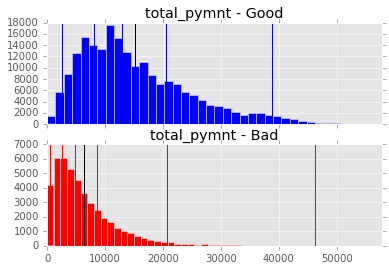

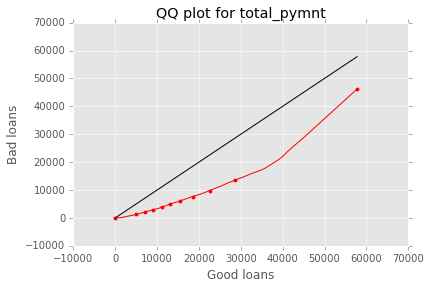

---------------------------
total_pymnt_inv: dtype=float64, 0 nulls, count vals=235567
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2334.94     7931.41    12868.26    20430.31    38791.88    57777.58
BAD        0.00      419.42     2460.31     4809.99     8545.52    20643.98    46162.55


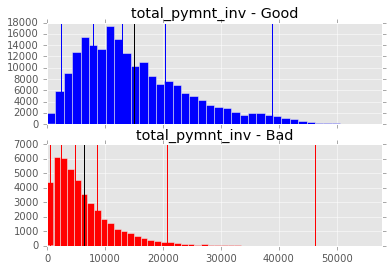

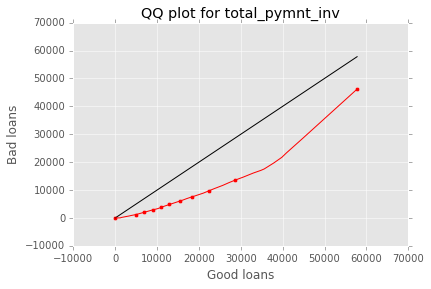

---------------------------
total_rec_prncp: dtype=float64, 0 nulls, count vals=44945
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2200.00     7075.00    11999.97    18000.00    35000.00    35000.03
BAD        0.00      144.23     1103.17     2319.40     4448.95    12154.24    34483.27


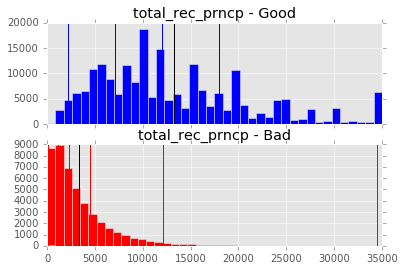

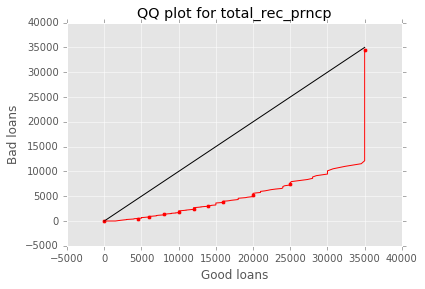

---------------------------
total_rec_int: dtype=float64, 0 nulls, count vals=182889
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       76.81      619.30     1284.80     2428.32     7657.80    22777.58
BAD        0.00       92.25      683.55     1430.36     2770.92     8451.62    20610.17


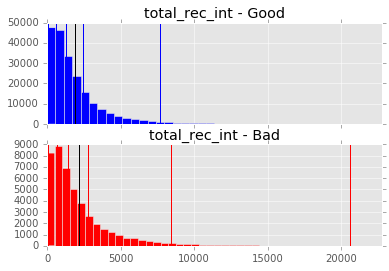

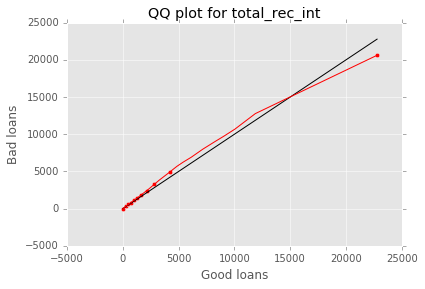

---------------------------
total_rec_late_fee: dtype=float64, 0 nulls, count vals=4448
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00      286.75
BAD        0.00        0.00        0.00        0.00        0.00       30.93      358.68


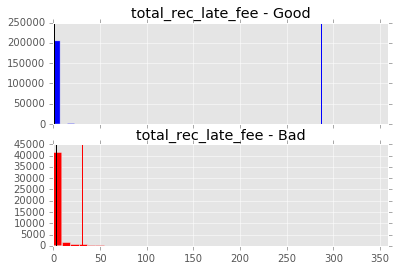

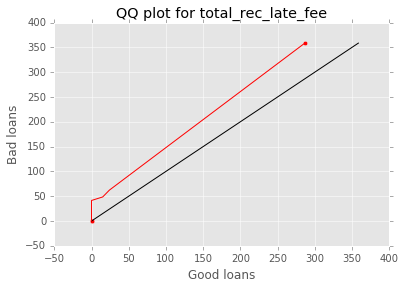

---------------------------
recoveries: dtype=float64, 0 nulls, count vals=22627
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00        0.00
BAD        0.00        0.00        0.00       35.06     1259.55     4800.17    33520.27


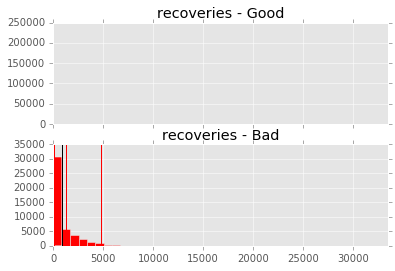

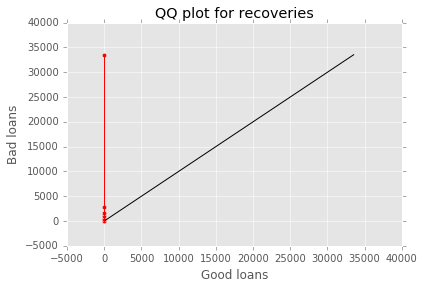

---------------------------
collection_recovery_fee: dtype=float64, 0 nulls, count vals=20529
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00        0.00
BAD        0.00        0.00        0.00        1.07       26.64      809.76     7002.19


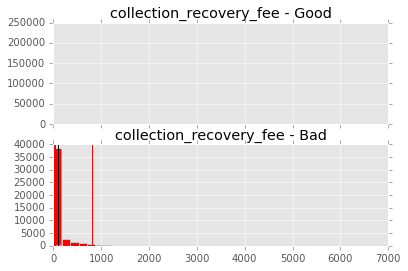

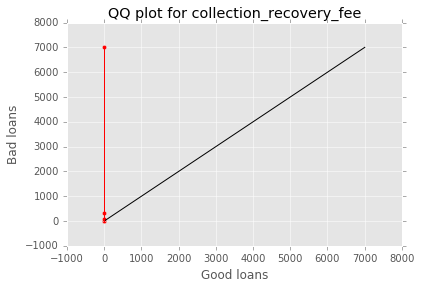

---------------------------
last_pymnt_d: dtype=object, 527 nulls, count vals=97
Total number of distinct values: 97
         Total     Good  Defaults  % Defaults
2015-07  14472  11335.0    3137.0   21.676341
2015-10  12503  12182.0     321.0    2.567384
2015-12  12159  12044.0     115.0    0.945801
2015-08  12011  10063.0    1948.0   16.218466
2015-06  11976   9354.0    2622.0   21.893788
2015-09  11245  10595.0     650.0    5.780347
2015-04  11102   8907.0    2195.0   19.771212
2015-05  11064   8699.0    2365.0   21.375633
2015-03  10755   8613.0    2142.0   19.916318
2015-11  10692  10570.0     122.0    1.141040
2015-02   8848   7202.0    1646.0   18.603074
2015-01   8653   6965.0    1688.0   19.507685
2014-10   7671   5923.0    1748.0   22.787120
2014-12   7249   5568.0    1681.0   23.189405
2014-09   6315   4765.0    1550.0   24.544735
2014-07   6312   4938.0    1374.0   21.768061
2014-08   6301   4850.0    1451.0   23.028091
2014-11   6202   4815.0    1387.0   22.363754
2014-06  

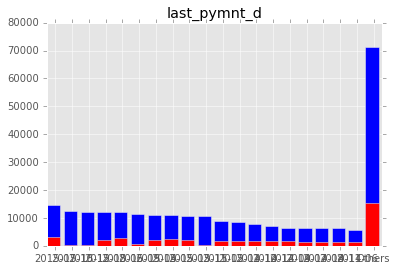

---------------------------
last_pymnt_amnt: dtype=float64, 0 nulls, count vals=199266
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       63.86     1555.19     5749.59    11663.59    27572.56    36475.59
BAD        0.00       30.21      235.83      374.99      568.55     1177.42    34833.35


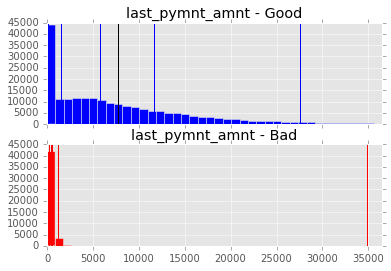

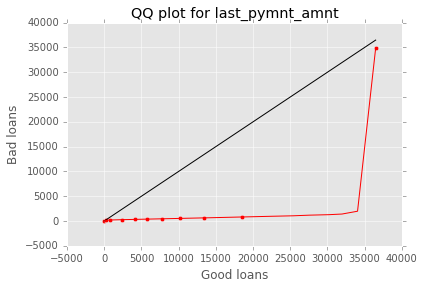

---------------------------
next_pymnt_d: dtype=float64, 252971 nulls, count vals=0
Total number of distinct values: 0
Empty DataFrame
Columns: [Total, Good, Defaults, % Defaults]
Index: []


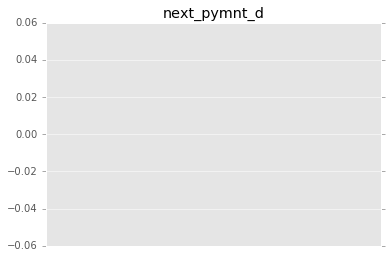

---------------------------
last_credit_pull_d: dtype=object, 21 nulls, count vals=102
Total number of distinct values: 102
          Total     Good  Defaults  % Defaults
2016-01  102053  82162.0   19891.0   19.490853
2015-12   18489  14777.0    3712.0   20.076802
2015-11   10935  10872.0      63.0    0.576132
2015-10    9936   9866.0      70.0    0.704509
2015-09    9698   8649.0    1049.0   10.816663
2015-07    8334   7182.0    1152.0   13.822894
2015-08    7730   6641.0    1089.0   14.087969
2015-06    6910   5887.0    1023.0   14.804631
2015-04    5999   5055.0     944.0   15.735956
2015-05    5762   4867.0     895.0   15.532801
2015-03    5639   4473.0    1166.0   20.677425
2015-02    4886   3857.0    1029.0   21.060172
2015-01    4770   3641.0    1129.0   23.668763
2014-12    3666   2725.0     941.0   25.668303
2014-10    3331   2630.0     701.0   21.044731
2014-11    3147   2359.0     788.0   25.039720
2014-09    2930   2308.0     622.0   21.228669
2014-08    2792   2187.0     6

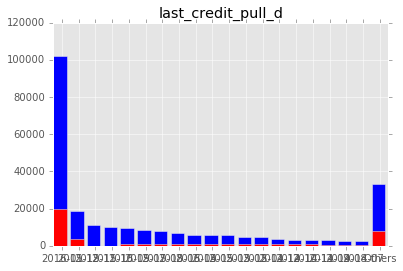

---------------------------
collections_12_mths_ex_med: dtype=float64, 56 nulls, count vals=7
Total number of distinct values: 7
      Total      Good  Defaults  % Defaults
0.0  251341  206444.0   44897.0   17.862983
1.0    1466    1139.0     327.0   22.305593
2.0      96      79.0      17.0   17.708333
3.0       8       8.0       0.0    0.000000
4.0       2       1.0       1.0   50.000000
6.0       1       1.0       0.0    0.000000
5.0       1       1.0       0.0    0.000000


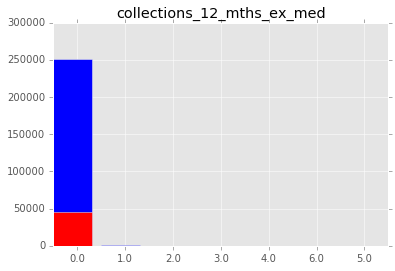

---------------------------
mths_since_last_major_derog: dtype=float64, 205426 nulls, count vals=149
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        7.00       27.00       43.00       60.00       80.00      159.00
BAD        0.00        6.00       25.00       42.00       60.00       80.00      152.00


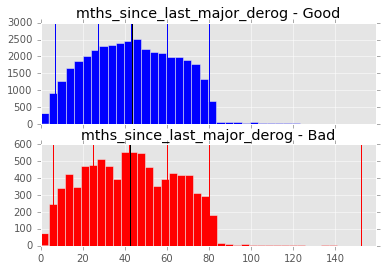

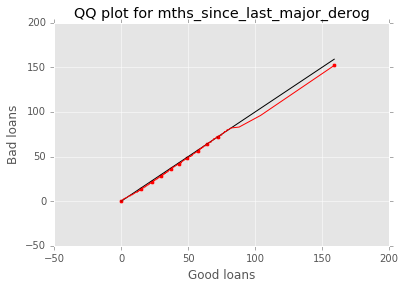

---------------------------
policy_code: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
1.0  252971  207723     45248   17.886635


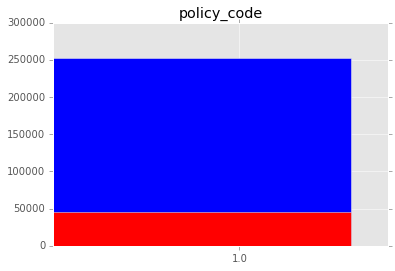

---------------------------
application_type: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
             Total      Good  Defaults  % Defaults
INDIVIDUAL  252970  207722.0   45248.0   17.886706
JOINT            1       1.0       0.0    0.000000


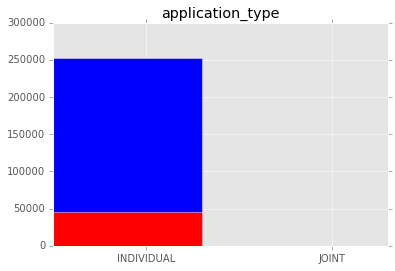

---------------------------
annual_inc_joint: dtype=float64, 252970 nulls, count vals=1
Total number of distinct values: 1
         Total  Good  Defaults  % Defaults
36000.0      1   1.0       0.0         0.0


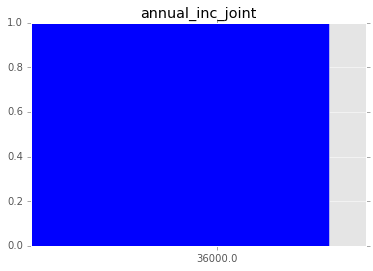

---------------------------
dti_joint: dtype=float64, 252970 nulls, count vals=1
Total number of distinct values: 1
      Total  Good  Defaults  % Defaults
17.6      1   1.0       0.0         0.0


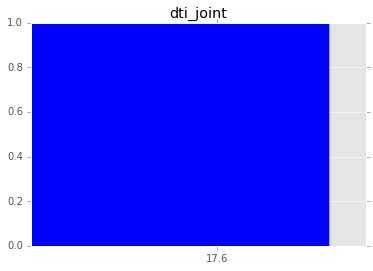

---------------------------
verification_status_joint: dtype=object, 252970 nulls, count vals=1
Total number of distinct values: 1
                 Total  Good  Defaults  % Defaults
Source Verified      1   1.0       0.0         0.0


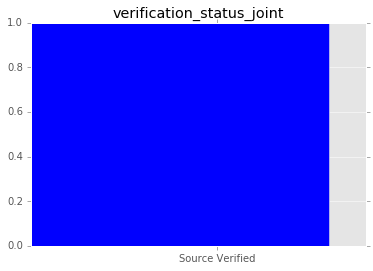

---------------------------
acc_now_delinq: dtype=float64, 0 nulls, count vals=6
Total number of distinct values: 6
      Total      Good  Defaults  % Defaults
0.0  252236  207148.0   45088.0   17.875323
1.0     693     545.0     148.0   21.356421
2.0      36      27.0       9.0   25.000000
3.0       3       1.0       2.0   66.666667
5.0       2       1.0       1.0   50.000000
4.0       1       1.0       0.0    0.000000


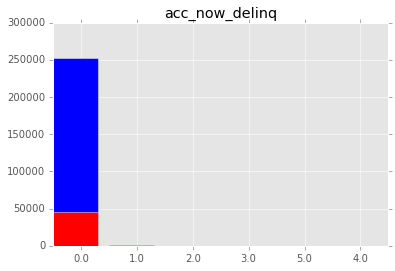

---------------------------
tot_coll_amt: dtype=float64, 63708 nulls, count vals=4029
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00     1061.00  9152545.00
BAD        0.00        0.00        0.00        0.00        0.00      972.00    95806.00


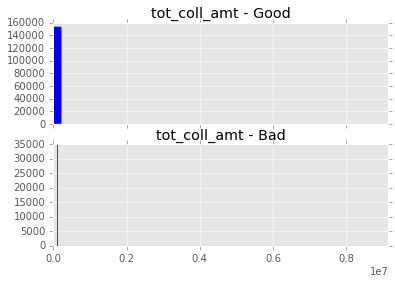

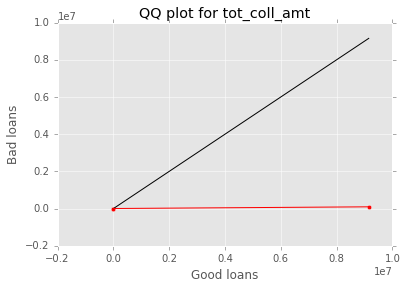

---------------------------
tot_cur_bal: dtype=float64, 63708 nulls, count vals=134747
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     5508.48    29146.25    87779.00   216689.75   524726.75  8000078.00
BAD        0.00     5878.70    25670.00    59738.00   172573.00   434454.90  3437283.00


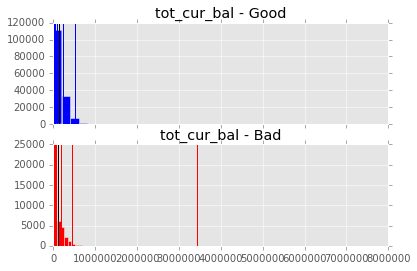

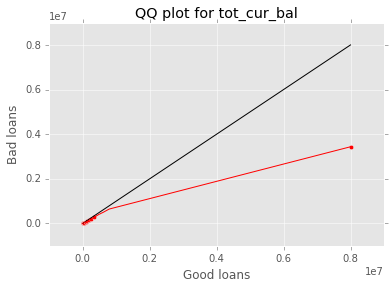

---------------------------
open_acc_6m: dtype=float64, 252827 nulls, count vals=7
Total number of distinct values: 7
     Total  Good  Defaults  % Defaults
0.0     46  46.0       0.0         0.0
2.0     38  38.0       0.0         0.0
1.0     36  36.0       0.0         0.0
3.0     14  14.0       0.0         0.0
4.0      5   5.0       0.0         0.0
5.0      3   3.0       0.0         0.0
6.0      2   2.0       0.0         0.0


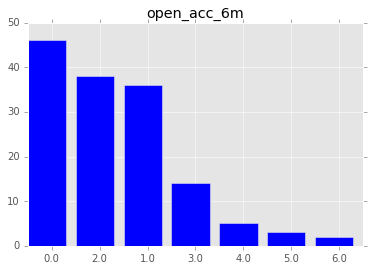

---------------------------
open_il_6m: dtype=float64, 252827 nulls, count vals=16
Total number of distinct values: 16
      Total  Good  Defaults  % Defaults
1.0      35  35.0       0.0         0.0
2.0      28  28.0       0.0         0.0
3.0      23  23.0       0.0         0.0
0.0      17  17.0       0.0         0.0
4.0      14  14.0       0.0         0.0
5.0       8   8.0       0.0         0.0
11.0      3   3.0       0.0         0.0
9.0       3   3.0       0.0         0.0
6.0       3   3.0       0.0         0.0
10.0      2   2.0       0.0         0.0
8.0       2   2.0       0.0         0.0
7.0       2   2.0       0.0         0.0
18.0      1   1.0       0.0         0.0
16.0      1   1.0       0.0         0.0
13.0      1   1.0       0.0         0.0
12.0      1   1.0       0.0         0.0


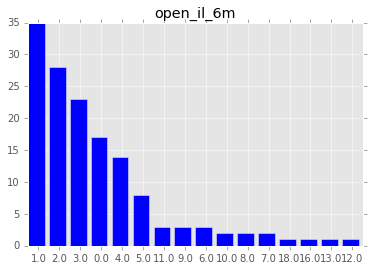

---------------------------
open_il_12m: dtype=float64, 252827 nulls, count vals=7
Total number of distinct values: 7
     Total  Good  Defaults  % Defaults
0.0     74  74.0       0.0         0.0
1.0     39  39.0       0.0         0.0
2.0     15  15.0       0.0         0.0
3.0     10  10.0       0.0         0.0
4.0      3   3.0       0.0         0.0
5.0      2   2.0       0.0         0.0
6.0      1   1.0       0.0         0.0


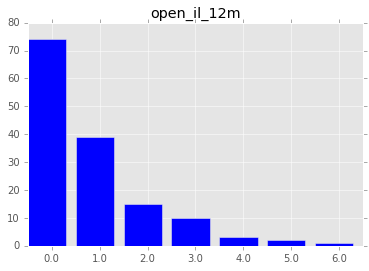

---------------------------
open_il_24m: dtype=float64, 252827 nulls, count vals=10
Total number of distinct values: 10
      Total  Good  Defaults  % Defaults
1.0      42  42.0       0.0         0.0
0.0      35  35.0       0.0         0.0
2.0      27  27.0       0.0         0.0
3.0      21  21.0       0.0         0.0
4.0       9   9.0       0.0         0.0
7.0       4   4.0       0.0         0.0
5.0       3   3.0       0.0         0.0
14.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
6.0       1   1.0       0.0         0.0


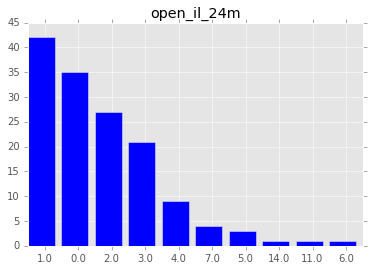

---------------------------
mths_since_rcnt_il: dtype=float64, 252831 nulls, count vals=50
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        1.00        4.00       12.50       21.00      111.05      141.00
BAD         nan         nan         nan         nan         nan         nan         nan


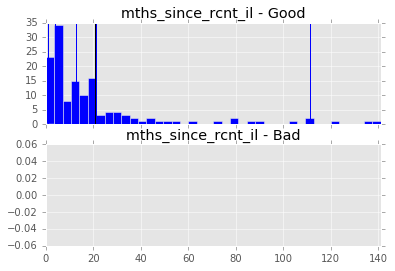

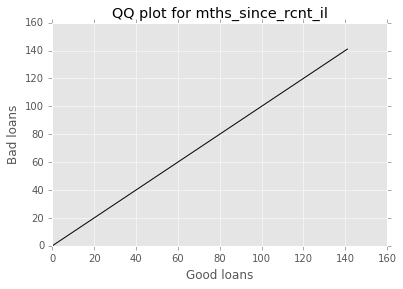

---------------------------
total_bal_il: dtype=float64, 252827 nulls, count vals=128
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00    10763.75    23605.00    50835.75   125035.20   249212.00
BAD         nan         nan         nan         nan         nan         nan         nan


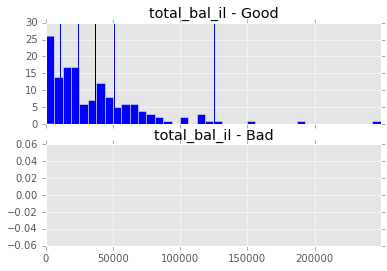

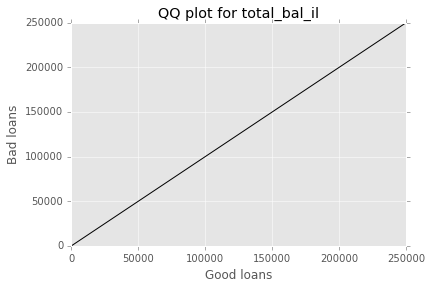

---------------------------
il_util: dtype=float64, 252845 nulls, count vals=116
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       23.31       63.35       77.05       88.25      110.81      129.20
BAD         nan         nan         nan         nan         nan         nan         nan


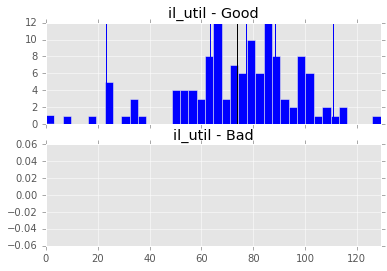

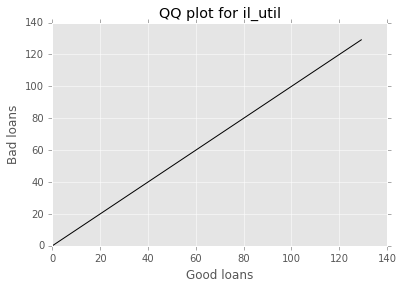

---------------------------
open_rv_12m: dtype=float64, 252827 nulls, count vals=8
Total number of distinct values: 8
     Total  Good  Defaults  % Defaults
1.0     39  39.0       0.0         0.0
0.0     39  39.0       0.0         0.0
2.0     31  31.0       0.0         0.0
3.0     18  18.0       0.0         0.0
5.0      8   8.0       0.0         0.0
4.0      6   6.0       0.0         0.0
7.0      2   2.0       0.0         0.0
8.0      1   1.0       0.0         0.0


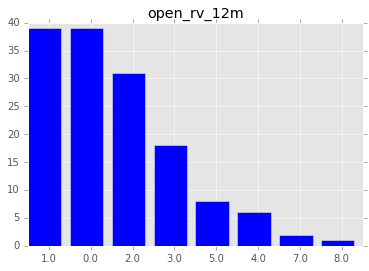

---------------------------
open_rv_24m: dtype=float64, 252827 nulls, count vals=14
Total number of distinct values: 14
      Total  Good  Defaults  % Defaults
2.0      29  29.0       0.0         0.0
1.0      23  23.0       0.0         0.0
4.0      19  19.0       0.0         0.0
3.0      18  18.0       0.0         0.0
5.0      15  15.0       0.0         0.0
0.0      12  12.0       0.0         0.0
6.0       9   9.0       0.0         0.0
7.0       7   7.0       0.0         0.0
9.0       5   5.0       0.0         0.0
8.0       3   3.0       0.0         0.0
21.0      1   1.0       0.0         0.0
12.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
10.0      1   1.0       0.0         0.0


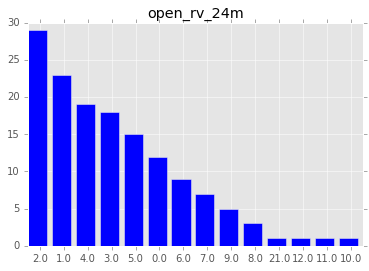

---------------------------
max_bal_bc: dtype=float64, 252827 nulls, count vals=139
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00     2091.25     4511.50     8212.75    16085.07    22279.00
BAD         nan         nan         nan         nan         nan         nan         nan


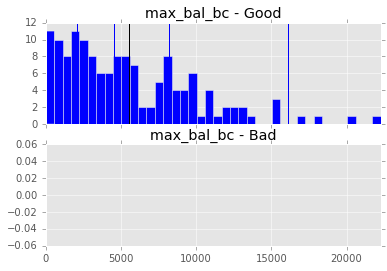

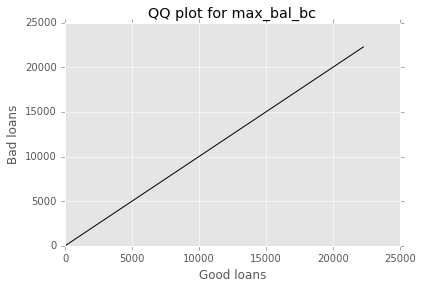

---------------------------
all_util: dtype=float64, 252827 nulls, count vals=126
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       7.90       18.38       46.82       61.95       74.23       91.87      102.80
BAD         nan         nan         nan         nan         nan         nan         nan


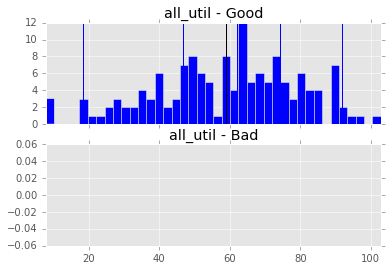

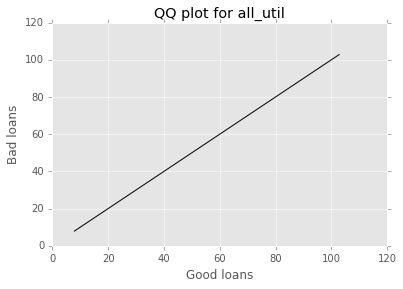

---------------------------
total_rev_hi_lim: dtype=float64, 63708 nulls, count vals=9543
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     4600.00    13500.00    22700.00    37800.00   101900.00  2013133.00
BAD        0.00     4000.00    12400.00    20500.00    33200.00    81330.00  1998700.00


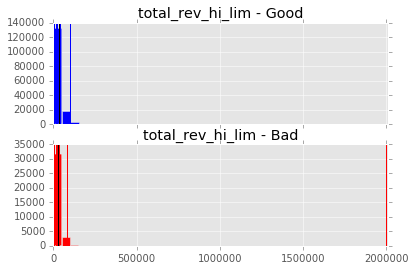

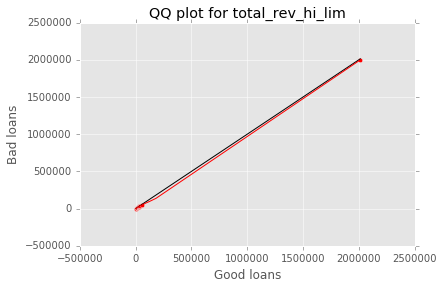

---------------------------
inq_fi: dtype=float64, 252827 nulls, count vals=9
Total number of distinct values: 9
     Total  Good  Defaults  % Defaults
0.0     62  62.0       0.0         0.0
1.0     47  47.0       0.0         0.0
2.0     12  12.0       0.0         0.0
3.0      7   7.0       0.0         0.0
4.0      5   5.0       0.0         0.0
7.0      4   4.0       0.0         0.0
5.0      4   4.0       0.0         0.0
6.0      2   2.0       0.0         0.0
9.0      1   1.0       0.0         0.0


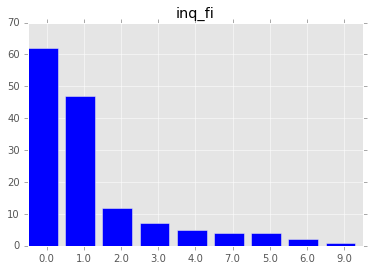

---------------------------
total_cu_tl: dtype=float64, 252827 nulls, count vals=18
Total number of distinct values: 18
      Total  Good  Defaults  % Defaults
0.0      78  78.0       0.0         0.0
1.0      17  17.0       0.0         0.0
2.0      16  16.0       0.0         0.0
3.0       8   8.0       0.0         0.0
4.0       5   5.0       0.0         0.0
7.0       3   3.0       0.0         0.0
12.0      3   3.0       0.0         0.0
5.0       2   2.0       0.0         0.0
6.0       2   2.0       0.0         0.0
8.0       2   2.0       0.0         0.0
18.0      1   1.0       0.0         0.0
9.0       1   1.0       0.0         0.0
10.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
13.0      1   1.0       0.0         0.0
15.0      1   1.0       0.0         0.0
17.0      1   1.0       0.0         0.0
21.0      1   1.0       0.0         0.0


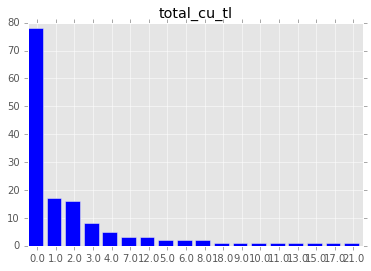

---------------------------
inq_last_12m: dtype=float64, 252827 nulls, count vals=17
Total number of distinct values: 17
       Total  Good  Defaults  % Defaults
 2.0      30  30.0       0.0         0.0
 1.0      25  25.0       0.0         0.0
 0.0      19  19.0       0.0         0.0
 3.0      19  19.0       0.0         0.0
-4.0      14  14.0       0.0         0.0
 6.0       8   8.0       0.0         0.0
 7.0       6   6.0       0.0         0.0
 4.0       6   6.0       0.0         0.0
 10.0      4   4.0       0.0         0.0
 5.0       4   4.0       0.0         0.0
 12.0      3   3.0       0.0         0.0
 11.0      1   1.0       0.0         0.0
 19.0      1   1.0       0.0         0.0
 13.0      1   1.0       0.0         0.0
 15.0      1   1.0       0.0         0.0
 16.0      1   1.0       0.0         0.0
 8.0       1   1.0       0.0         0.0


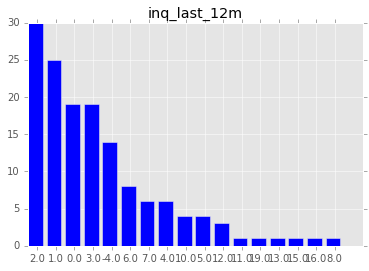

In [48]:
for column in lc_data.columns:
    explore_column(lc_data, column)

TODO on the data exploration:

* Parse dates (done)
* Fix fields that throw exception when plotting (e.g., dates) (done)
* Show min/max as well as quantiles (done)
* Treat dates as special and make subplots per year (or turn histograms into line charts accompanied by boxplots per year)
* Graphically show distribution of categorical values (done)
* Hand-coded ranking/combining of categorical values
* Cutoff should be > 10 (done)
* Color-code by outcome (done)
* Identify missing values
* qq plots against likely inputs
* Discard rows whose outcome is right-censored by selecting the two terminal loan_status values (done)

## Discussion of each column

---------------------------
id: dtype=int64, 0 nulls, count vals=252971
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   54734.00   461199.35  1439717.00  6225193.00  17212845.50  55111138.60  68604659.00
BAD    57167.00   500326.15  1568881.75  6581844.00  15021673.00  42505257.97  60516983.00


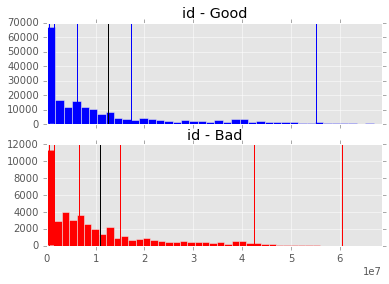

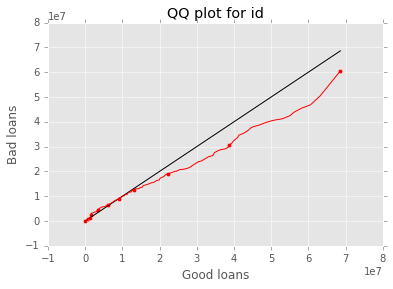

In [49]:
explore_column(lc_data, 'id')

* **id** Even though this doesn't show a difference between good and bad loans, it is interesting to see how the distribution of ids changes. Since this data set includes only loans that were funded, we might be able to approximate an estimate of what percentage of loans are approved.

---------------------------
member_id: dtype=int64, 0 nulls, count vals=252971
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   70699.00   573741.65  1684432.50  7450306.00  19225968.00  58681050.05  73507418.00
BAD    80353.00   641491.88  1824480.25  8047168.00  16742592.75  45472061.12  64537751.00


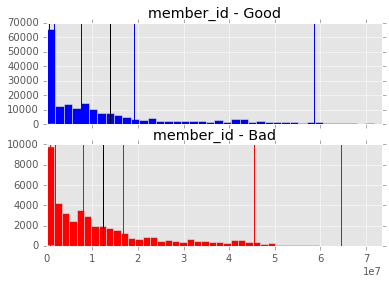

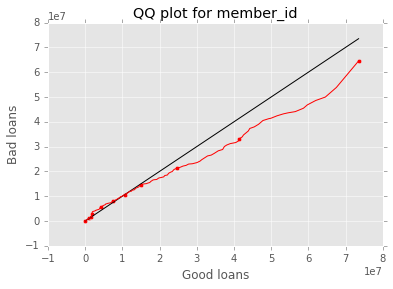

In [50]:
explore_column(lc_data, 'member_id')

* **member_id** Similar considerations come into play here as did for *id*

---------------------------
loan_amnt: dtype=float64, 0 nulls, count vals=1326
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2225.00     7200.00    12000.00    18000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12675.00    20000.00    35000.00    35000.00


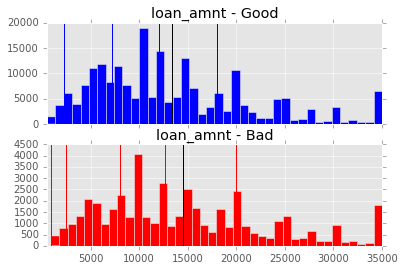

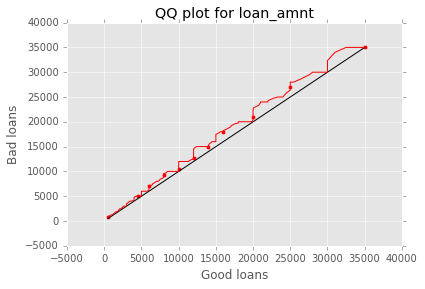

In [51]:
explore_column(lc_data, 'loan_amnt')

* **loan_amnt** These distributions look fairly similar, and I suspect that this column will have little independent value. However, it may have an interaction effect and we should keep it in our initial models.

---------------------------
funded_amnt: dtype=float64, 0 nulls, count vals=1326
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2200.00     7150.00    12000.00    18000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12600.00    20000.00    35000.00    35000.00


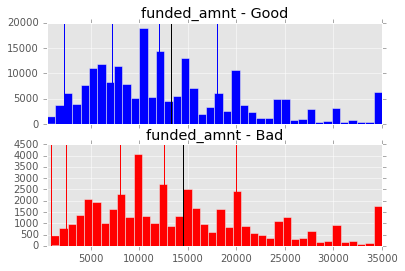

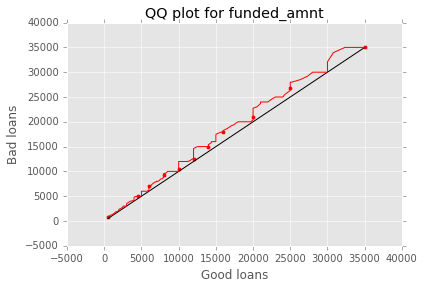

In [53]:
explore_column(lc_data, 'funded_amnt')

* **funded_amnt** is effectively the same as loan_amnt.

---------------------------
funded_amnt_inv: dtype=float64, 0 nulls, count vals=8527
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2000.00     7000.00    11725.00    18000.00    34975.00    35000.00
BAD        0.00     2400.00     8000.00    12375.00    19975.00    35000.00    35000.00


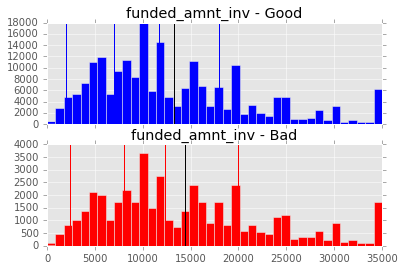

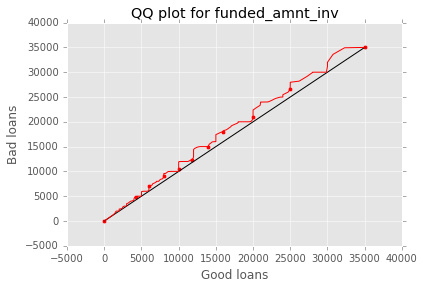

In [54]:
explore_column(lc_data, 'funded_amnt_inv')

* **funded_amnt_inv** is effectively the same as loan_amnt.

---------------------------
term: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
             Total    Good  Defaults  % Defaults
 36 months  196658  167575     29083   14.788618
 60 months   56313   40148     16165   28.705627


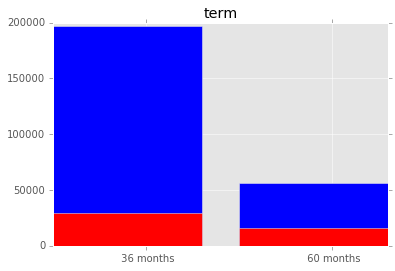

In [55]:
explore_column(lc_data, 'term')

* **term** 28% of the 60-month loans default, vs 14% of the 36-month loans. We will certainly want to inclue it in our model

---------------------------
int_rate: dtype=float64, 0 nulls, count vals=513
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       5.32        6.03       10.16       13.11       15.81       22.95       28.99
BAD        5.42        7.88       13.05       15.80       18.92       24.83       28.99


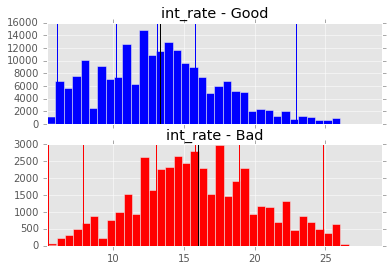

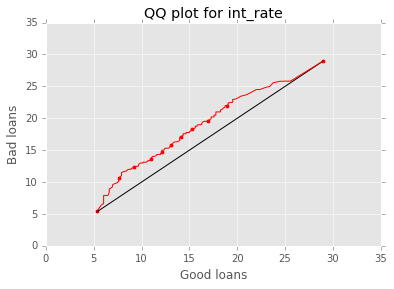

In [56]:
explore_column(lc_data, 'int_rate')

* **int_rate** is a field which LC derives from other inputs, using a proprietary formula which may change over time (even if we were to attempt to correct for changes in the underlying interest rate market). As such, we do not consider it a reliable predictor and we choose to exclude it.

---------------------------
installment: dtype=float64, 0 nulls, count vals=45487
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD      15.69       74.08      234.36      360.08      540.56     1029.71     1409.99
BAD       21.62       85.62      265.18      390.83      573.32     1033.01     1424.57


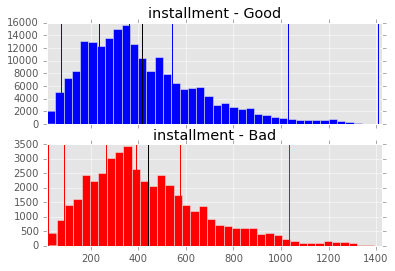

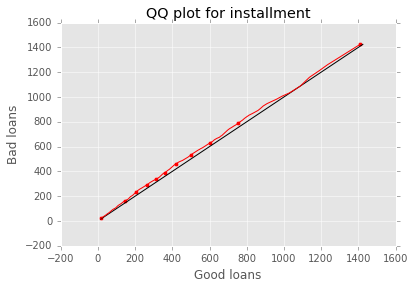

In [57]:
explore_column(lc_data, 'installment')

* **installment**

---------------------------
grade: dtype=object, 0 nulls, count vals=7
Total number of distinct values: 7
   Total   Good  Defaults  % Defaults
B  76065  66546      9519   12.514297
C  65320  52678     12642   19.353950
A  42296  39679      2617    6.187346
D  40506  30020     10486   25.887523
E  19186  12928      6258   32.617534
F   7660   4726      2934   38.302872
G   1938   1146       792   40.866873


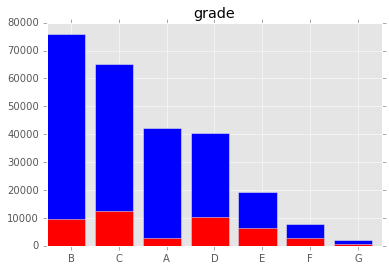

In [58]:
explore_column(lc_data, 'grade')

* **grade** is another proprietary formula that LC uses and whose definition may change over time. We prefer to exclude it from our analysis.

---------------------------
sub_grade: dtype=object, 0 nulls, count vals=35
Total number of distinct values: 35
        Total   Good  Defaults  % Defaults
B3      18068  15809      2259   12.502767
B4      16933  14610      2323   13.718774
C1      14959  12476      2483   16.598703
B2      14628  13035      1593   10.890074
C2      14341  11810      2531   17.648700
B5      14340  12209      2131   14.860530
C3      12778  10227      2551   19.964001
B1      12096  10883      1213   10.028108
C4      12056   9492      2564   21.267419
A5      11993  11012       981    8.179772
C5      11186   8673      2513   22.465582
A4      11058  10279       779    7.044674
D1      10046   7678      2368   23.571571
D2       9051   6781      2270   25.080102
D3       7991   5951      2040   25.528720
D4       7384   5299      2085   28.236728
A3       7173   6774       399    5.562526
A2       6202   5925       277    4.466301
D5       6034   4311      1723   28.554856
Others  34654  24489     101

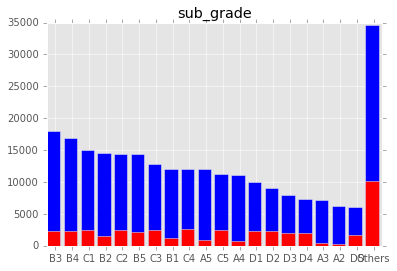

In [59]:
explore_column(lc_data, 'sub_grade')

* **sub_grade**, like `grade`, is a proprietary metric whose definition may change over time. 

---------------------------
emp_title: dtype=object, 13928 nulls, count vals=132762
Total number of distinct values: 132762
                   Total      Good  Defaults  % Defaults
Manager             1941    1560.0     381.0   19.629057
Teacher             1909    1594.0     315.0   16.500786
Supervisor           852     686.0     166.0   19.483568
Registered Nurse     841     689.0     152.0   18.073722
RN                   841     698.0     143.0   17.003567
Sales                677     538.0     139.0   20.531758
Project Manager      669     582.0      87.0   13.004484
manager              579     418.0     161.0   27.806563
Office Manager       568     488.0      80.0   14.084507
Driver               534     394.0     140.0   26.217228
Director             501     438.0      63.0   12.574850
Engineer             470     411.0      59.0   12.553191
Owner                459     348.0     111.0   24.183007
US Army              457     377.0      80.0   17.505470
General Manager      

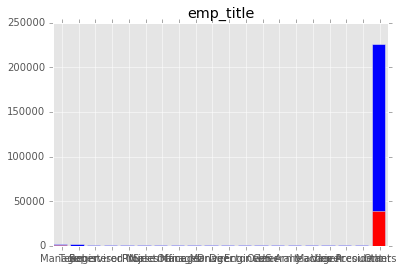

In [60]:
explore_column(lc_data, 'emp_title')

* **emp_title** is a factor with many possible values, some of which will undoubtedly show greater or lesser default rates. Whether those changes will turn out to be significant is worth investigating.

---------------------------
emp_length: dtype=object, 0 nulls, count vals=12
Total number of distinct values: 12
           Total   Good  Defaults  % Defaults
10+ years  76881  63748     13133   17.082244
2 years    23561  19528      4033   17.117270
< 1 year   20886  17033      3853   18.447764
3 years    20380  16846      3534   17.340530
5 years    18059  14856      3203   17.736309
1 year     16856  13892      2964   17.584243
4 years    16197  13422      2775   17.132802
6 years    14753  12058      2695   18.267471
7 years    14085  11483      2602   18.473553
8 years    11849   9695      2154   18.178749
n/a         9897   7372      2525   25.512782
9 years     9567   7790      1777   18.574266


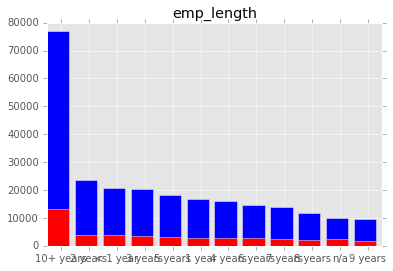

In [61]:
explore_column(lc_data, 'emp_length')

* **emp_length**

---------------------------
home_ownership: dtype=object, 0 nulls, count vals=6
Total number of distinct values: 6
           Total      Good  Defaults  % Defaults
MORTGAGE  124844  104966.0   19878.0   15.922271
RENT      105957   84646.0   21311.0   20.112876
OWN        21985   17960.0    4025.0   18.307937
OTHER        141     114.0      27.0   19.148936
NONE          43      36.0       7.0   16.279070
ANY            1       1.0       0.0    0.000000


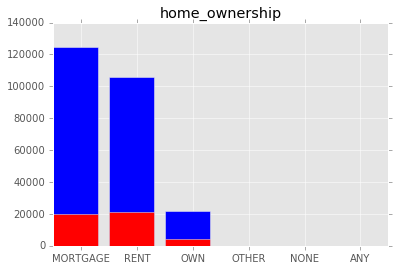

In [62]:
explore_column(lc_data, 'home_ownership')

* **home_ownership** seems likely to have an effect; `MORTGAGE` shows up with a much lower default rate than the other large cohorts. We should include this.

---------------------------
annual_inc: dtype=float64, 0 nulls, count vals=19483
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD    3000.00    24000.00    45000.00    64162.00    90000.00   180000.00  7141778.00
BAD     4080.00    21180.70    40000.00    56000.00    78000.00   160000.00  8706582.00


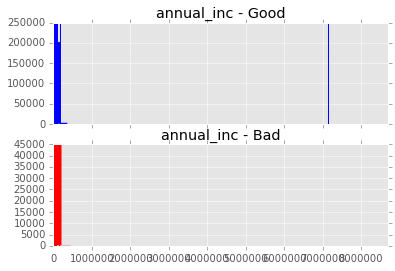

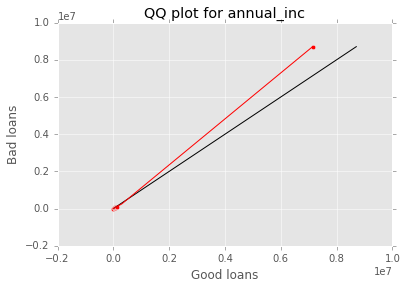

In [63]:
explore_column(lc_data, 'annual_inc')

* **annual_inc** The extrema are messing up our exploratory chart, but just looking at the difference in quantiles between the "good" and "bad" cohorts, it's clear that this is an important predictor.

---------------------------
verification_status: dtype=object, 0 nulls, count vals=3
Total number of distinct values: 3
                 Total   Good  Defaults  % Defaults
Verified         92896  73596     19300   20.775921
Not Verified     86064  73856     12208   14.184793
Source Verified  74011  60271     13740   18.564808


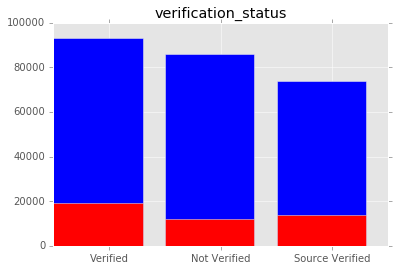

In [64]:
explore_column(lc_data, 'verification_status')

* **verification_status** The surprising thing here is that *verified* income information has a higher default rate than "not verified." This may have an interesting interaction term with income.

---------------------------
issue_d: dtype=object, 0 nulls, count vals=103
Total number of distinct values: 103
          Total      Good  Defaults  % Defaults
2014-10    8727    7005.0    1722.0   19.731867
2014-07    8527    6773.0    1754.0   20.569954
2014-04    6702    5266.0    1436.0   21.426440
2013-11    6642    5287.0    1355.0   20.400482
2013-10    6636    5264.0    1372.0   20.675105
2013-12    6623    5345.0    1278.0   19.296391
2014-01    6489    5214.0    1275.0   19.648636
2013-08    6401    5030.0    1371.0   21.418528
2014-05    6391    5048.0    1343.0   21.013926
2013-09    6350    5007.0    1343.0   21.149606
2013-07    6159    4800.0    1359.0   22.065270
2014-03    6141    4875.0    1266.0   20.615535
2013-06    6016    4674.0    1342.0   22.307181
2013-05    5876    4560.0    1316.0   22.396188
2014-02    5864    4598.0    1266.0   21.589359
2012-11    5863    4932.0     931.0   15.879243
2012-10    5835    4946.0     889.0   15.235647
2012-09    5688    4798.

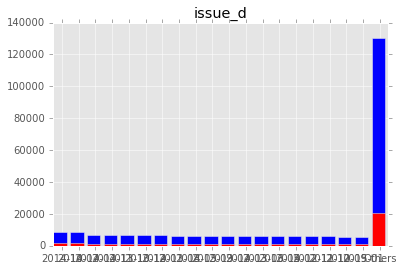

In [65]:
explore_column(lc_data, 'issue_d')

* **issue_d** The issue date of the loan itself has no useful value; even if there is a strong secular trend I would be disinclined to use it for predictions. On the other hand, to the degree that this allows us to correct for the strength of the economy in normalizing historical data, it should probably be included in our model.

---------------------------
loan_status: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
              Total      Good  Defaults  % Defaults
Fully Paid   207723  207723.0       0.0         0.0
Charged Off   45248       0.0   45248.0       100.0


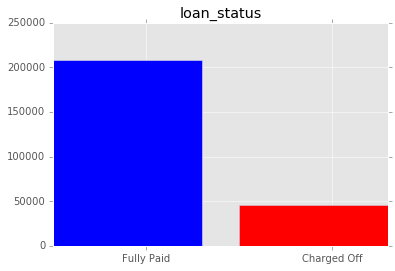

In [66]:
explore_column(lc_data, 'loan_status')

* **loan_status** is what we're trying to predict.

---------------------------
pymnt_plan: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
    Total      Good  Defaults  % Defaults
n  252969  207721.0   45248.0   17.886777
y       2       2.0       0.0    0.000000


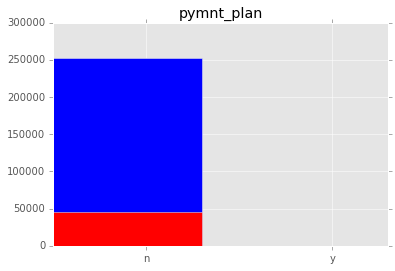

In [67]:
explore_column(lc_data, 'pymnt_plan')

* **pymnt_plan** does not have enough "y" values to be useful.

* **url** is really just a decorator around the id field, and can be discarded.

---------------------------
desc: dtype=object, 164651 nulls, count vals=87640
Total number of distinct values: 87640
                                                    Total     Good  Defaults  \
                                                      216    188.0      28.0   
Debt Consolidation                                     10      5.0       5.0   
Camping Membership                                      6      5.0       1.0   
  Borrower added on 03/10/14 > Debt consolidati...      6      2.0       4.0   
  Borrower added on 01/03/14 > Debt consolidati...      5      4.0       1.0   
  Borrower added on 12/02/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 11/14/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 12/16/13 > Debt consolidati...      4      4.0       0.0   
  Borrower added on 02/27/14 > Debt consolidati...      4      3.0       1.0   
  Borrower added on 10/01/12 > Debt consolidati...      4      3.0       1.0   
  

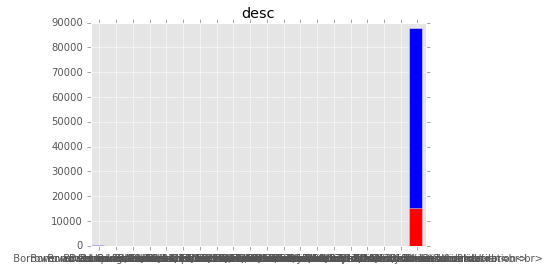

In [69]:
explore_column(lc_data, 'desc')

* **desc** This exploration is unable to start extracting features from the description field. We will deal with that separately. We certainly hope to focus on this.

---------------------------
purpose: dtype=object, 0 nulls, count vals=14
Total number of distinct values: 14
                     Total    Good  Defaults  % Defaults
debt_consolidation  148363  120764     27599   18.602347
credit_card          50076   42250      7826   15.628245
home_improvement     14929   12660      2269   15.198607
other                14277   11341      2936   20.564544
major_purchase        6265    5391       874   13.950519
small_business        4746    3375      1371   28.887484
car                   3646    3198       448   12.287438
medical               2854    2285       569   19.936931
moving                2028    1603       425   20.956607
wedding               1955    1690       265   13.554987
house                 1652    1366       286   17.312349
vacation              1588    1318       270   17.002519
educational            325     269        56   17.230769
renewable_energy       267     213        54   20.224719


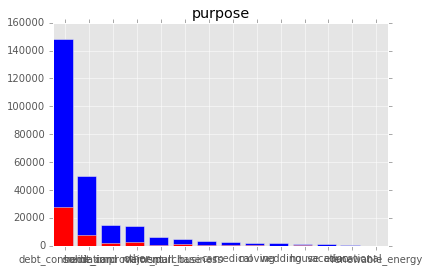

In [70]:
explore_column(lc_data, 'purpose')

* **purpose** clearly has strong predictive value and should be included.

---------------------------
title: dtype=object, 12 nulls, count vals=47929
Total number of distinct values: 47929
                            Total     Good  Defaults  % Defaults
Debt consolidation          72074  58597.0   13477.0   18.698837
Credit card refinancing     22794  19079.0    3715.0   16.298149
Debt Consolidation          11092   9226.0    1866.0   16.822935
Home improvement             6741   5680.0    1061.0   15.739505
Other                        6036   4749.0    1287.0   21.322068
Consolidation                3570   2998.0     572.0   16.022409
debt consolidation           3215   2437.0     778.0   24.199067
Debt Consolidation Loan      3058   2556.0     502.0   16.415958
Major purchase               2158   1811.0     347.0   16.079703
Business                     1743   1224.0     519.0   29.776248
Credit Card Consolidation    1626   1429.0     197.0   12.115621
Personal Loan                1606   1356.0     250.0   15.566625
consolidation                1380   1090

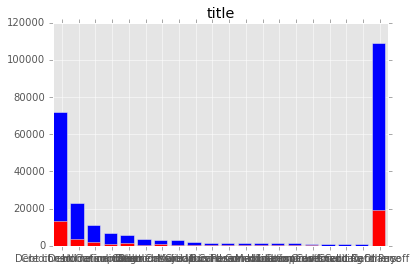

In [71]:
explore_column(lc_data, 'title')

* **title** seems to be related to `purpose` -- we will include one or the other of them, but there's no point in both.

---------------------------
zip_code: dtype=object, 0 nulls, count vals=886
Total number of distinct values: 886
         Total      Good  Defaults  % Defaults
945xx     3286    2784.0     502.0   15.276932
112xx     2832    2281.0     551.0   19.456215
750xx     2767    2333.0     434.0   15.684857
100xx     2522    2165.0     357.0   14.155432
900xx     2474    2054.0     420.0   16.976556
606xx     2449    2097.0     352.0   14.373214
331xx     2286    1795.0     491.0   21.478565
300xx     2279    1919.0     360.0   15.796402
070xx     2192    1786.0     406.0   18.521898
917xx     2080    1678.0     402.0   19.326923
770xx     1964    1667.0     297.0   15.122200
921xx     1959    1614.0     345.0   17.611026
891xx     1950    1493.0     457.0   23.435897
926xx     1874    1551.0     323.0   17.235859
330xx     1847    1459.0     388.0   21.007038
913xx     1672    1383.0     289.0   17.284689
104xx     1669    1298.0     371.0   22.228880
117xx     1646    1324.0     322.0   19.5

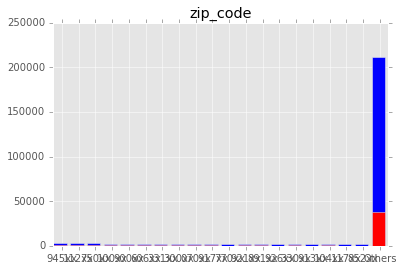

In [72]:
explore_column(lc_data, 'zip_code')

* **zip_code** will also need to be dealt with separately, but certainly should have some predictive value.

---------------------------
addr_state: dtype=object, 0 nulls, count vals=51
Total number of distinct values: 51
        Total     Good  Defaults  % Defaults
CA      43110  35778.0    7332.0   17.007655
NY      21338  17214.0    4124.0   19.327022
TX      19343  16308.0    3035.0   15.690431
FL      17545  14021.0    3524.0   20.085494
NJ       9601   7760.0    1841.0   19.175086
IL       9253   7711.0    1542.0   16.664865
PA       8399   6842.0    1557.0   18.537921
GA       8014   6654.0    1360.0   16.970302
VA       7942   6504.0    1438.0   18.106270
OH       7738   6266.0    1472.0   19.023003
NC       6919   5613.0    1306.0   18.875560
MA       6139   5122.0    1017.0   16.566216
AZ       6077   5028.0    1049.0   17.261807
MD       6007   4907.0    1100.0   18.311969
MI       5996   4846.0    1150.0   19.179453
WA       5915   4929.0     986.0   16.669484
CO       5613   4829.0     784.0   13.967575
MN       4460   3657.0     803.0   18.004484
MO       3954   3173.0     781.0

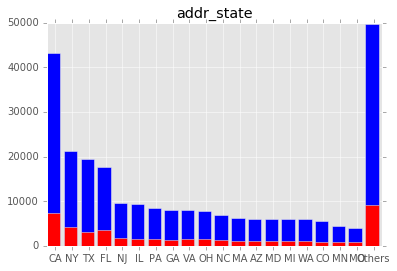

In [73]:
explore_column(lc_data, 'addr_state')

* **addr_state** is going into the model.

---------------------------
dti: dtype=float64, 0 nulls, count vals=3978
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        2.53       10.42       15.75       21.48       32.02       57.14
BAD        0.00        3.49       12.57       18.35       24.09       33.64       39.98


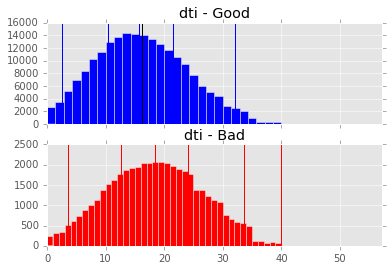

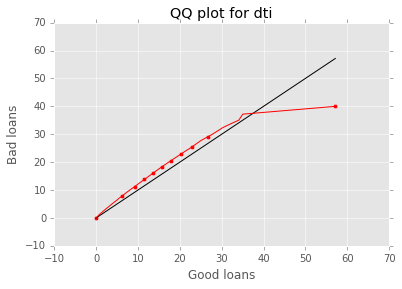

In [74]:
explore_column(lc_data, 'dti')

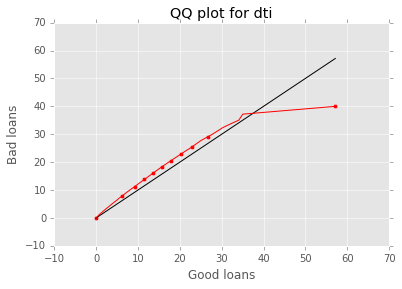

In [75]:
good_bad_quantile_plot(lc_data, 'dti')

* **dti** The "debt-to-income" ratio. The difference between the two distributions is striking. We will certainly want to include this.

---------------------------
delinq_2yrs: dtype=float64, 0 nulls, count vals=22
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        2.00       29.00
BAD        0.00        0.00        0.00        0.00        0.00        2.00       18.00


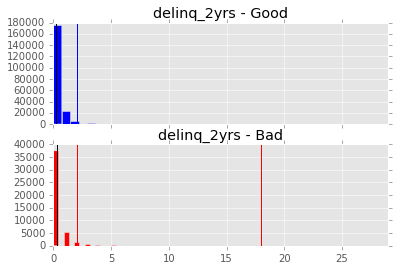

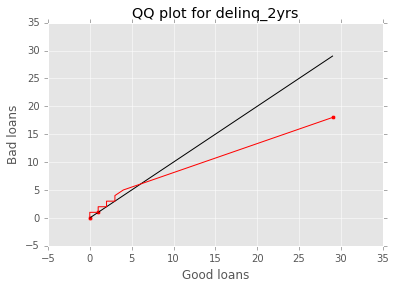

In [76]:
explore_column(lc_data, 'delinq_2yrs')

* **delinq_2yrs** This may want to be converted to a categorical factor: 0, 1, >1

---------------------------
earliest_cr_line: dtype=object, 0 nulls, count vals=644
Total number of distinct values: 644
          Total      Good  Defaults  % Defaults
2000-10    2112    1747.0     365.0   17.282197
1999-10    1965    1673.0     292.0   14.860051
2001-10    1958    1640.0     318.0   16.241062
2000-11    1925    1590.0     335.0   17.402597
2000-08    1922    1570.0     352.0   18.314256
1999-11    1890    1566.0     324.0   17.142857
2001-08    1798    1486.0     312.0   17.352614
2000-12    1763    1432.0     331.0   18.774816
2000-09    1763    1472.0     291.0   16.505956
2001-09    1725    1451.0     274.0   15.884058
2002-10    1716    1429.0     287.0   16.724942
1998-12    1711    1404.0     307.0   17.942724
1999-12    1698    1389.0     309.0   18.197880
1999-08    1665    1348.0     317.0   19.039039
2001-01    1643    1342.0     301.0   18.320146
1999-09    1643    1339.0     304.0   18.502739
2002-09    1639    1356.0     283.0   17.266626
1998-11    1633

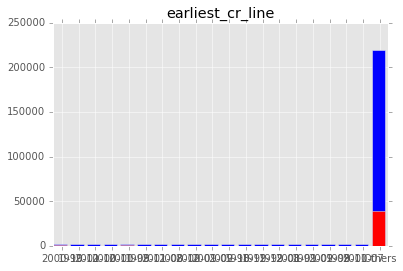

In [78]:
explore_column(lc_data, 'earliest_cr_line')

* **earliest_cr_line**

---------------------------
inq_last_6mths: dtype=float64, 0 nulls, count vals=9
Total number of distinct values: 9
      Total    Good  Defaults  % Defaults
0.0  123762  104123     19639   15.868360
1.0   72735   59208     13527   18.597649
2.0   34768   27611      7157   20.585021
3.0   16059   12400      3659   22.784731
4.0    3692    2878       814   22.047671
5.0    1374    1075       299   21.761281
6.0     517     380       137   26.499033
7.0      46      34        12   26.086957
8.0      18      14         4   22.222222


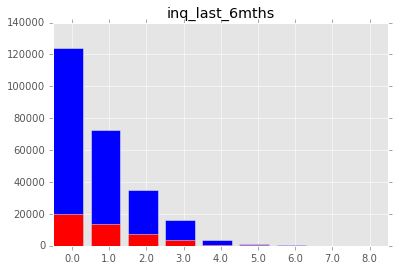

In [79]:
explore_column(lc_data, 'inq_last_6mths')

* **inq_last_6mths**

---------------------------
mths_since_last_delinq: dtype=float64, 140820 nulls, count vals=127
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        3.00       17.00       33.00       51.00       78.00      151.00
BAD        0.00        3.00       15.00       31.00       50.00       78.00      152.00


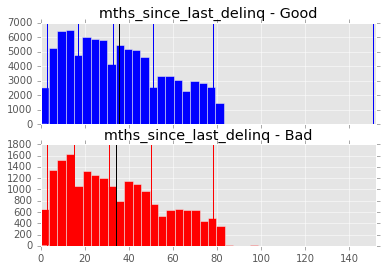

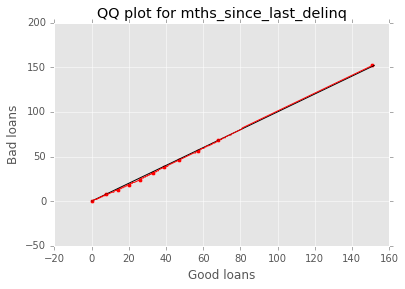

In [80]:
explore_column(lc_data, 'mths_since_last_delinq')

* **mths_since_last_delinq**

---------------------------
mths_since_last_record: dtype=float64, 221373 nulls, count vals=123
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        7.00       54.00       77.00      101.00      117.00      121.00
BAD        0.00        8.00       58.00       86.00      103.00      117.00      129.00


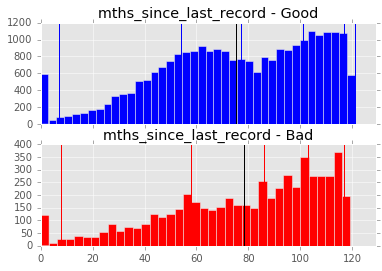

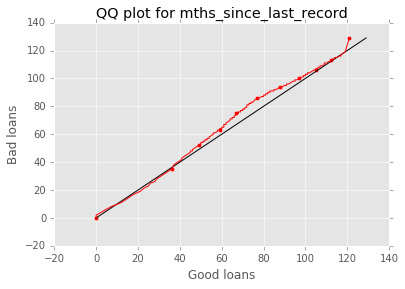

In [81]:
explore_column(lc_data, 'mths_since_last_record')

* **mths_since_last_record**

---------------------------
open_acc: dtype=float64, 0 nulls, count vals=59
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        4.00        7.00       10.00       13.00       23.00       58.00
BAD        0.00        4.00        8.00       10.00       14.00       23.00       76.00


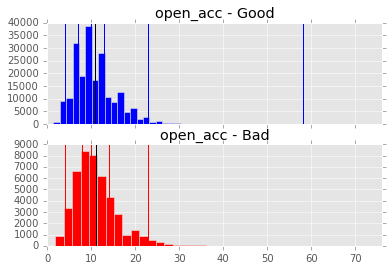

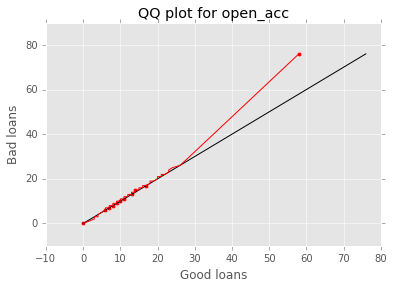

In [82]:
explore_column(lc_data, 'open_acc')

* **open_acc**

---------------------------
pub_rec: dtype=float64, 0 nulls, count vals=14
Total number of distinct values: 14
       Total      Good  Defaults  % Defaults
0.0   222043  182315.0   39728.0   17.892030
1.0    27332   22494.0    4838.0   17.700863
2.0     2547    2064.0     483.0   18.963486
3.0      676     563.0     113.0   16.715976
4.0      202     158.0      44.0   21.782178
5.0       92      67.0      25.0   27.173913
6.0       39      30.0       9.0   23.076923
7.0       19      14.0       5.0   26.315789
8.0        8       8.0       0.0    0.000000
10.0       5       5.0       0.0    0.000000
9.0        5       3.0       2.0   40.000000
15.0       1       1.0       0.0    0.000000
12.0       1       0.0       1.0  100.000000
11.0       1       1.0       0.0    0.000000


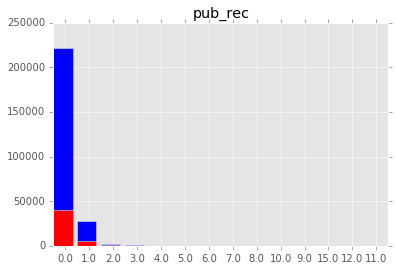

In [83]:
explore_column(lc_data, 'pub_rec')

* **pub_rec**

---------------------------
revol_bal: dtype=float64, 0 nulls, count vals=47316
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00      600.00     5786.00    10848.00    19041.00    52239.85  1743266.00
BAD        0.00      770.00     6226.75    11351.50    19204.00    47578.12  1746716.00


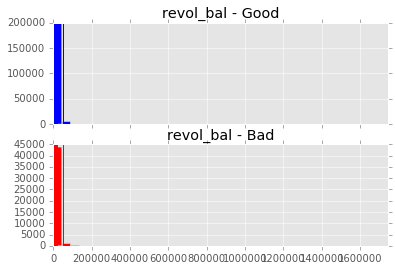

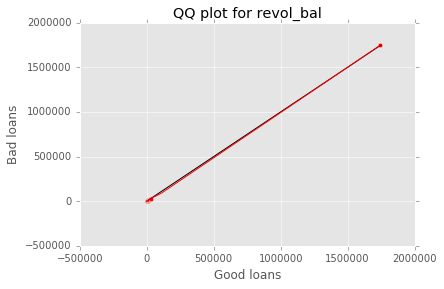

In [84]:
explore_column(lc_data, 'revol_bal')

* **revol_bal**

---------------------------
revol_util: dtype=float64, 199 nulls, count vals=1199
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        4.10       34.90       54.50       72.80       95.10      892.30
BAD        0.00        8.50       43.30       61.60       78.00       96.50      129.40


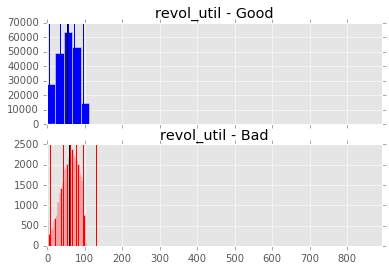

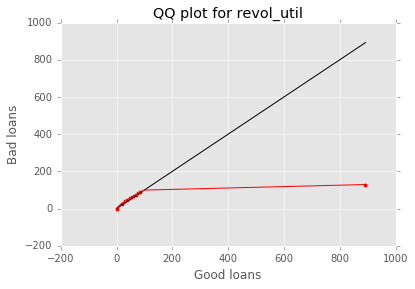

In [85]:
explore_column(lc_data, 'revol_util')

* **revol_util**

---------------------------
total_acc: dtype=float64, 0 nulls, count vals=105
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       2.00        7.00       17.00       24.00       32.00       53.00      150.00
BAD        2.00        7.00       16.00       23.00       31.00       51.00      110.00


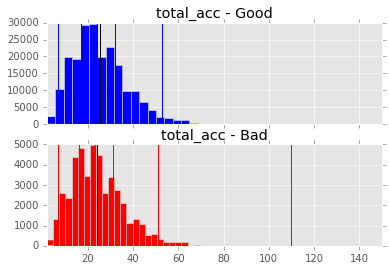

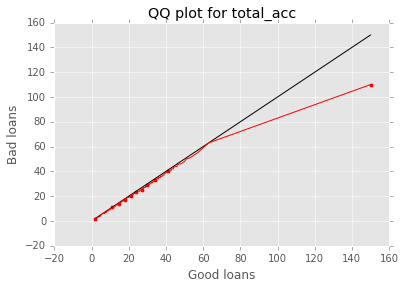

In [86]:
explore_column(lc_data, 'total_acc')

* **total_acc**

---------------------------
initial_list_status: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
    Total    Good  Defaults  % Defaults
f  182079  149146     32933   18.087204
w   70892   58577     12315   17.371495


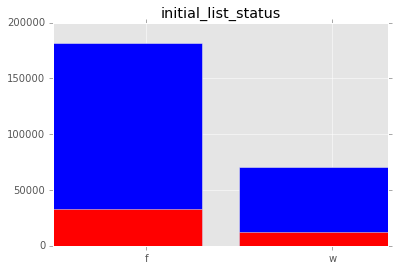

In [87]:
explore_column(lc_data, 'initial_list_status')

* **initial_list_status**

---------------------------
out_prncp: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
0.0  252971  207723     45248   17.886635


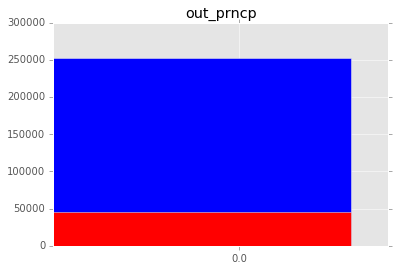

In [88]:
explore_column(lc_data, 'out_prncp')

* **out_prncp**

---------------------------
out_prncp_inv: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
0.0  252971  207723     45248   17.886635


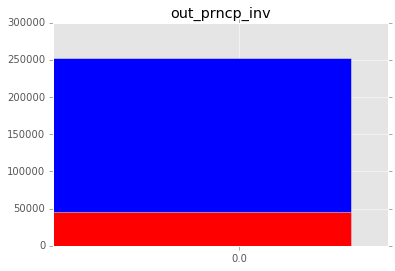

In [89]:
explore_column(lc_data, 'out_prncp_inv')

* **out_prncp_inv**

---------------------------
total_pymnt: dtype=float64, 0 nulls, count vals=242391
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2489.47     8056.40    12963.17    20538.34    38874.17    57777.58
BAD        0.00      459.07     2502.76     4873.24     8624.95    20765.46    46199.44


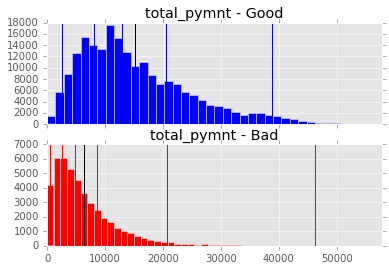

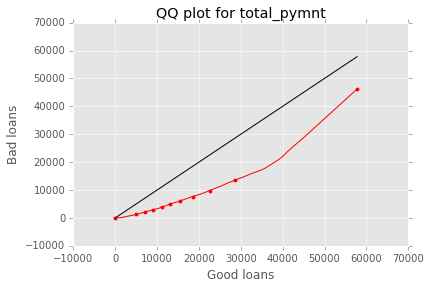

In [90]:
explore_column(lc_data, 'total_pymnt')

* **total_pymnt**

---------------------------
total_pymnt_inv: dtype=float64, 0 nulls, count vals=235567
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2334.94     7931.41    12868.26    20430.31    38791.88    57777.58
BAD        0.00      419.42     2460.31     4809.99     8545.52    20643.98    46162.55


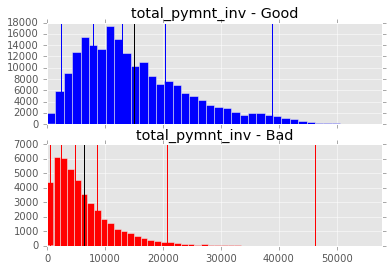

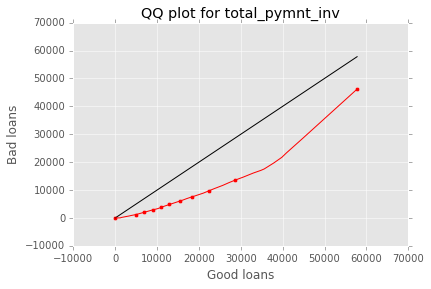

In [91]:
explore_column(lc_data, 'total_pymnt_inv')

* **total_pymnt_inv**

---------------------------
total_rec_prncp: dtype=float64, 0 nulls, count vals=44945
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2200.00     7075.00    11999.97    18000.00    35000.00    35000.03
BAD        0.00      144.23     1103.17     2319.40     4448.95    12154.24    34483.27


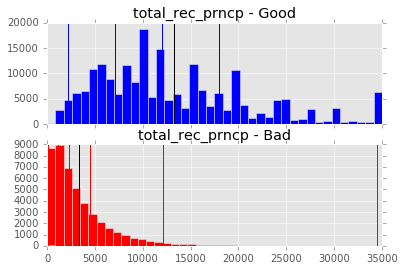

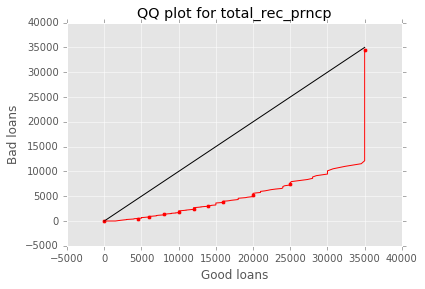

In [92]:
explore_column(lc_data, 'total_rec_prncp')

* **total_rec_prncp**

---------------------------
total_rec_int: dtype=float64, 0 nulls, count vals=182889
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       76.81      619.30     1284.80     2428.32     7657.80    22777.58
BAD        0.00       92.25      683.55     1430.36     2770.92     8451.62    20610.17


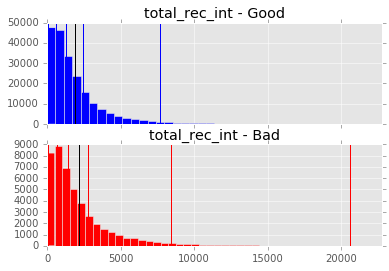

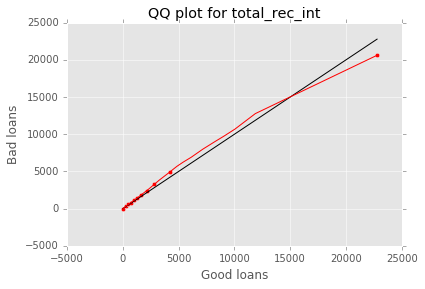

In [93]:
explore_column(lc_data, 'total_rec_int')

* **total_rec_int**

---------------------------
total_rec_late_fee: dtype=float64, 0 nulls, count vals=4448
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00      286.75
BAD        0.00        0.00        0.00        0.00        0.00       30.93      358.68


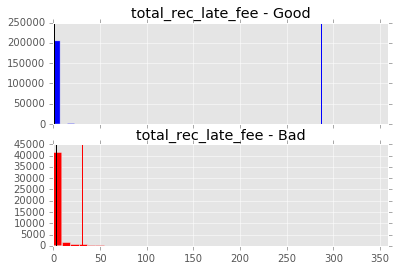

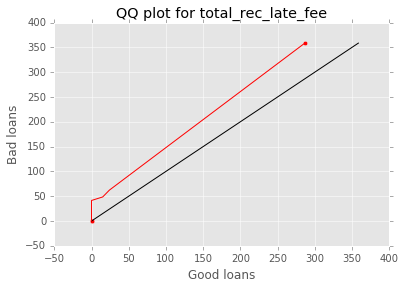

In [94]:
explore_column(lc_data, 'total_rec_late_fee')

* **total_rec_late_fee**

---------------------------
recoveries: dtype=float64, 0 nulls, count vals=22627
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00        0.00
BAD        0.00        0.00        0.00       35.06     1259.55     4800.17    33520.27


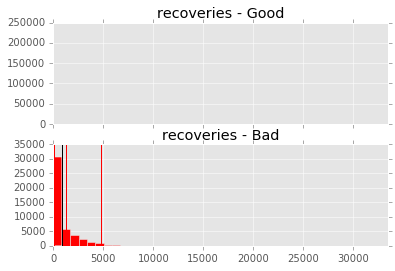

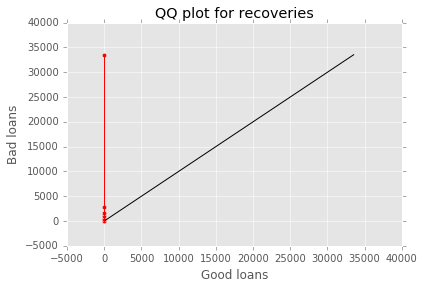

In [95]:
explore_column(lc_data, 'recoveries')

* **recoveries**

---------------------------
collection_recovery_fee: dtype=float64, 0 nulls, count vals=20529
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00        0.00
BAD        0.00        0.00        0.00        1.07       26.64      809.76     7002.19


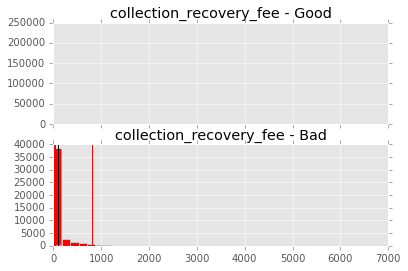

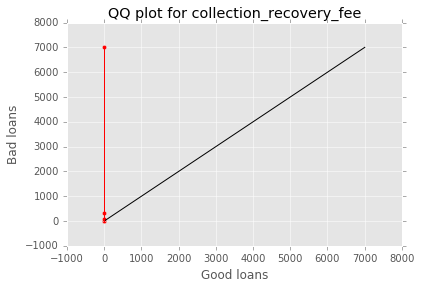

In [96]:
explore_column(lc_data, 'collection_recovery_fee')

* **collection_recovery_fee**

---------------------------
last_pymnt_d: dtype=object, 527 nulls, count vals=97
Total number of distinct values: 97
         Total     Good  Defaults  % Defaults
2015-07  14472  11335.0    3137.0   21.676341
2015-10  12503  12182.0     321.0    2.567384
2015-12  12159  12044.0     115.0    0.945801
2015-08  12011  10063.0    1948.0   16.218466
2015-06  11976   9354.0    2622.0   21.893788
2015-09  11245  10595.0     650.0    5.780347
2015-04  11102   8907.0    2195.0   19.771212
2015-05  11064   8699.0    2365.0   21.375633
2015-03  10755   8613.0    2142.0   19.916318
2015-11  10692  10570.0     122.0    1.141040
2015-02   8848   7202.0    1646.0   18.603074
2015-01   8653   6965.0    1688.0   19.507685
2014-10   7671   5923.0    1748.0   22.787120
2014-12   7249   5568.0    1681.0   23.189405
2014-09   6315   4765.0    1550.0   24.544735
2014-07   6312   4938.0    1374.0   21.768061
2014-08   6301   4850.0    1451.0   23.028091
2014-11   6202   4815.0    1387.0   22.363754
2014-06  

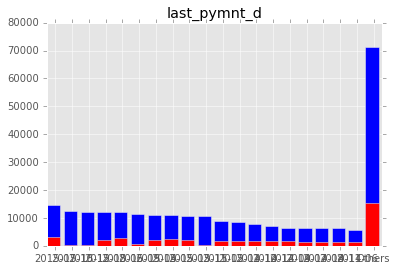

In [97]:
explore_column(lc_data, 'last_pymnt_d')

* **last_pymnt_d**

---------------------------
last_pymnt_amnt: dtype=float64, 0 nulls, count vals=199266
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       63.86     1555.19     5749.59    11663.59    27572.56    36475.59
BAD        0.00       30.21      235.83      374.99      568.55     1177.42    34833.35


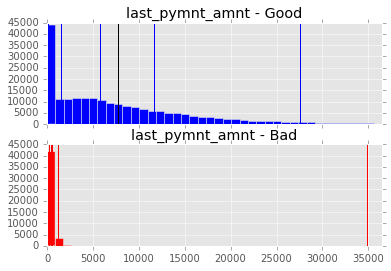

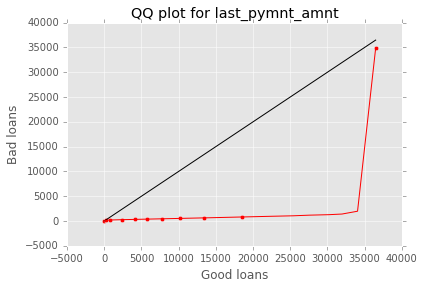

In [98]:
explore_column(lc_data, 'last_pymnt_amnt')

* **last_pymnt_amnt**

---------------------------
next_pymnt_d: dtype=float64, 252971 nulls, count vals=0
Total number of distinct values: 0
Empty DataFrame
Columns: [Total, Good, Defaults, % Defaults]
Index: []


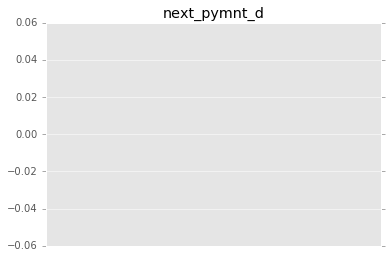

In [99]:
explore_column(lc_data, 'next_pymnt_d')

* **next_pymnt_d**

---------------------------
last_credit_pull_d: dtype=object, 21 nulls, count vals=102
Total number of distinct values: 102
          Total     Good  Defaults  % Defaults
2016-01  102053  82162.0   19891.0   19.490853
2015-12   18489  14777.0    3712.0   20.076802
2015-11   10935  10872.0      63.0    0.576132
2015-10    9936   9866.0      70.0    0.704509
2015-09    9698   8649.0    1049.0   10.816663
2015-07    8334   7182.0    1152.0   13.822894
2015-08    7730   6641.0    1089.0   14.087969
2015-06    6910   5887.0    1023.0   14.804631
2015-04    5999   5055.0     944.0   15.735956
2015-05    5762   4867.0     895.0   15.532801
2015-03    5639   4473.0    1166.0   20.677425
2015-02    4886   3857.0    1029.0   21.060172
2015-01    4770   3641.0    1129.0   23.668763
2014-12    3666   2725.0     941.0   25.668303
2014-10    3331   2630.0     701.0   21.044731
2014-11    3147   2359.0     788.0   25.039720
2014-09    2930   2308.0     622.0   21.228669
2014-08    2792   2187.0     6

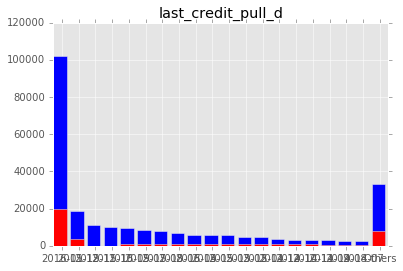

In [100]:
explore_column(lc_data, 'last_credit_pull_d')

* **last_credit_pull_d**

---------------------------
collections_12_mths_ex_med: dtype=float64, 56 nulls, count vals=7
Total number of distinct values: 7
      Total      Good  Defaults  % Defaults
0.0  251341  206444.0   44897.0   17.862983
1.0    1466    1139.0     327.0   22.305593
2.0      96      79.0      17.0   17.708333
3.0       8       8.0       0.0    0.000000
4.0       2       1.0       1.0   50.000000
6.0       1       1.0       0.0    0.000000
5.0       1       1.0       0.0    0.000000


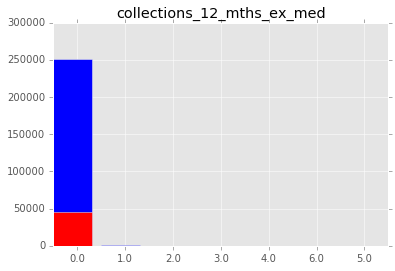

In [101]:
explore_column(lc_data, 'collections_12_mths_ex_med')

* **collections_12_mths_ex_med**

---------------------------
mths_since_last_major_derog: dtype=float64, 205426 nulls, count vals=149
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        7.00       27.00       43.00       60.00       80.00      159.00
BAD        0.00        6.00       25.00       42.00       60.00       80.00      152.00


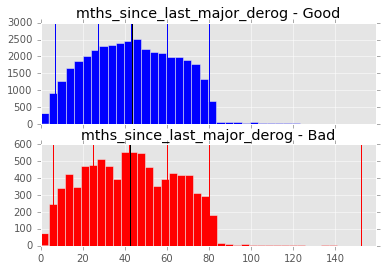

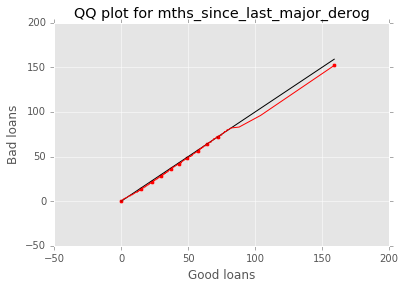

In [102]:
explore_column(lc_data, 'mths_since_last_major_derog')

* **mths_since_last_major_derog**

---------------------------
policy_code: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
      Total    Good  Defaults  % Defaults
1.0  252971  207723     45248   17.886635


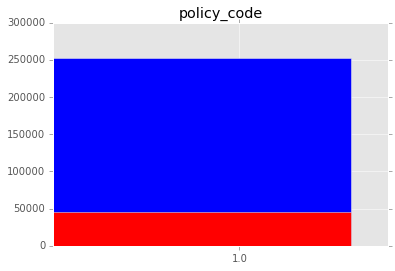

In [103]:
explore_column(lc_data, 'policy_code')

* **policy_code**

---------------------------
application_type: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
             Total      Good  Defaults  % Defaults
INDIVIDUAL  252970  207722.0   45248.0   17.886706
JOINT            1       1.0       0.0    0.000000


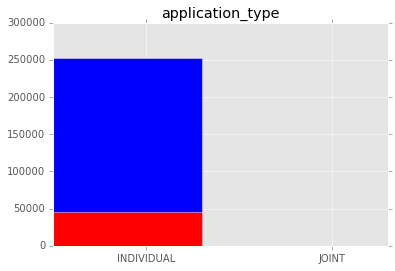

In [104]:
explore_column(lc_data, 'application_type')

* **application_type**

---------------------------
annual_inc_joint: dtype=float64, 252970 nulls, count vals=1
Total number of distinct values: 1
         Total  Good  Defaults  % Defaults
36000.0      1   1.0       0.0         0.0


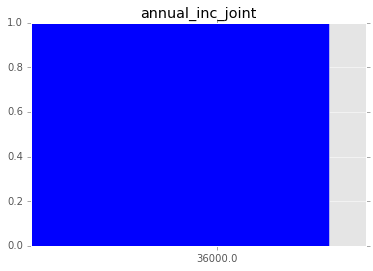

In [105]:
explore_column(lc_data, 'annual_inc_joint')

* **annual_inc_joint**

---------------------------
dti_joint: dtype=float64, 252970 nulls, count vals=1
Total number of distinct values: 1
      Total  Good  Defaults  % Defaults
17.6      1   1.0       0.0         0.0


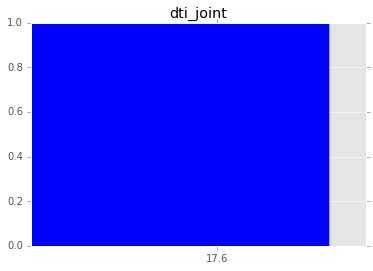

In [106]:
explore_column(lc_data, 'dti_joint')

* **dti_joint**

---------------------------
verification_status_joint: dtype=object, 252970 nulls, count vals=1
Total number of distinct values: 1
                 Total  Good  Defaults  % Defaults
Source Verified      1   1.0       0.0         0.0


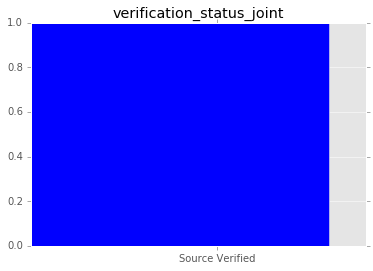

In [107]:
explore_column(lc_data, 'verification_status_joint')

* **verification_status_joint**

---------------------------
acc_now_delinq: dtype=float64, 0 nulls, count vals=6
Total number of distinct values: 6
      Total      Good  Defaults  % Defaults
0.0  252236  207148.0   45088.0   17.875323
1.0     693     545.0     148.0   21.356421
2.0      36      27.0       9.0   25.000000
3.0       3       1.0       2.0   66.666667
5.0       2       1.0       1.0   50.000000
4.0       1       1.0       0.0    0.000000


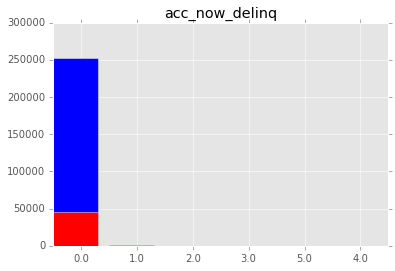

In [108]:
explore_column(lc_data, 'acc_now_delinq')

* **acc_now_delinq**

---------------------------
tot_coll_amt: dtype=float64, 63708 nulls, count vals=4029
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00     1061.00  9152545.00
BAD        0.00        0.00        0.00        0.00        0.00      972.00    95806.00


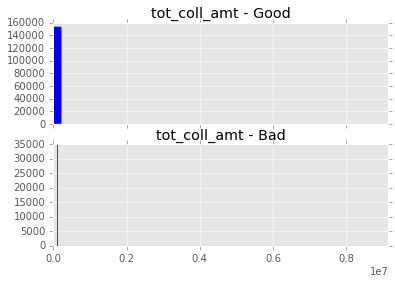

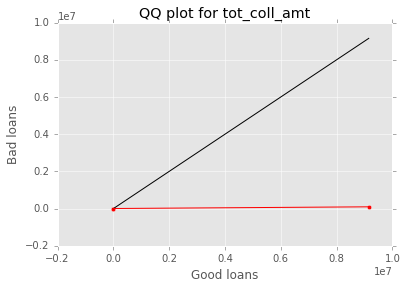

In [109]:
explore_column(lc_data, 'tot_coll_amt')

* **tot_coll_amt**

---------------------------
tot_cur_bal: dtype=float64, 63708 nulls, count vals=134747
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     5508.48    29146.25    87779.00   216689.75   524726.75  8000078.00
BAD        0.00     5878.70    25670.00    59738.00   172573.00   434454.90  3437283.00


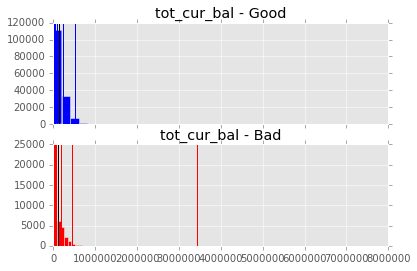

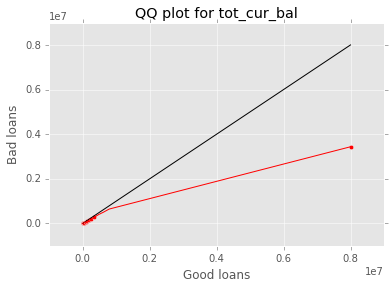

In [110]:
explore_column(lc_data, 'tot_cur_bal')

* **tot_cur_bal**

---------------------------
open_acc_6m: dtype=float64, 252827 nulls, count vals=7
Total number of distinct values: 7
     Total  Good  Defaults  % Defaults
0.0     46  46.0       0.0         0.0
2.0     38  38.0       0.0         0.0
1.0     36  36.0       0.0         0.0
3.0     14  14.0       0.0         0.0
4.0      5   5.0       0.0         0.0
5.0      3   3.0       0.0         0.0
6.0      2   2.0       0.0         0.0


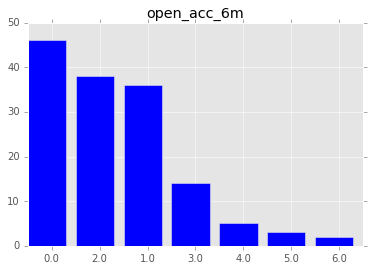

In [111]:
explore_column(lc_data, 'open_acc_6m')

* **open_acc_6m**

---------------------------
open_il_6m: dtype=float64, 252827 nulls, count vals=16
Total number of distinct values: 16
      Total  Good  Defaults  % Defaults
1.0      35  35.0       0.0         0.0
2.0      28  28.0       0.0         0.0
3.0      23  23.0       0.0         0.0
0.0      17  17.0       0.0         0.0
4.0      14  14.0       0.0         0.0
5.0       8   8.0       0.0         0.0
11.0      3   3.0       0.0         0.0
9.0       3   3.0       0.0         0.0
6.0       3   3.0       0.0         0.0
10.0      2   2.0       0.0         0.0
8.0       2   2.0       0.0         0.0
7.0       2   2.0       0.0         0.0
18.0      1   1.0       0.0         0.0
16.0      1   1.0       0.0         0.0
13.0      1   1.0       0.0         0.0
12.0      1   1.0       0.0         0.0


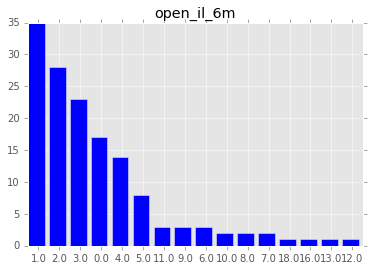

In [112]:
explore_column(lc_data, 'open_il_6m')

* **open_il_6m**

---------------------------
open_il_12m: dtype=float64, 252827 nulls, count vals=7
Total number of distinct values: 7
     Total  Good  Defaults  % Defaults
0.0     74  74.0       0.0         0.0
1.0     39  39.0       0.0         0.0
2.0     15  15.0       0.0         0.0
3.0     10  10.0       0.0         0.0
4.0      3   3.0       0.0         0.0
5.0      2   2.0       0.0         0.0
6.0      1   1.0       0.0         0.0


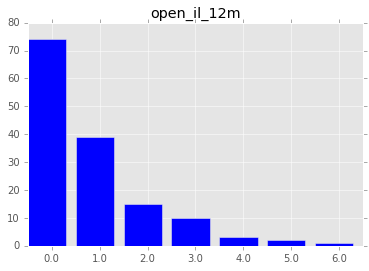

In [113]:
explore_column(lc_data, 'open_il_12m')

* **open_il_12m**

---------------------------
open_il_24m: dtype=float64, 252827 nulls, count vals=10
Total number of distinct values: 10
      Total  Good  Defaults  % Defaults
1.0      42  42.0       0.0         0.0
0.0      35  35.0       0.0         0.0
2.0      27  27.0       0.0         0.0
3.0      21  21.0       0.0         0.0
4.0       9   9.0       0.0         0.0
7.0       4   4.0       0.0         0.0
5.0       3   3.0       0.0         0.0
14.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
6.0       1   1.0       0.0         0.0


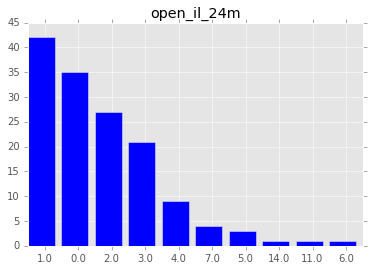

In [114]:
explore_column(lc_data, 'open_il_24m')

* **open_il_24m**

---------------------------
mths_since_rcnt_il: dtype=float64, 252831 nulls, count vals=50
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        1.00        4.00       12.50       21.00      111.05      141.00
BAD         nan         nan         nan         nan         nan         nan         nan


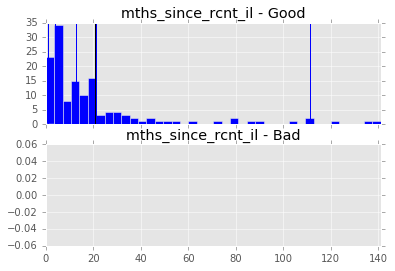

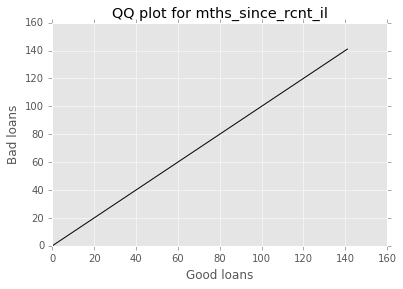

In [115]:
explore_column(lc_data, 'mths_since_rcnt_il')

* **mths_since_rcnt_il**

---------------------------
total_bal_il: dtype=float64, 252827 nulls, count vals=128
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00    10763.75    23605.00    50835.75   125035.20   249212.00
BAD         nan         nan         nan         nan         nan         nan         nan


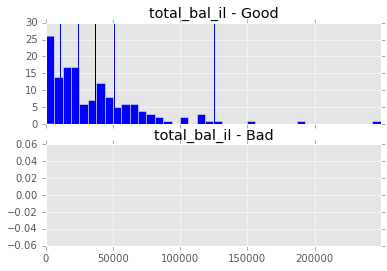

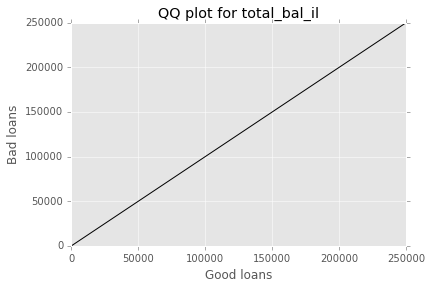

In [116]:
explore_column(lc_data, 'total_bal_il')

* **total_bal_il**

---------------------------
il_util: dtype=float64, 252845 nulls, count vals=116
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       23.31       63.35       77.05       88.25      110.81      129.20
BAD         nan         nan         nan         nan         nan         nan         nan


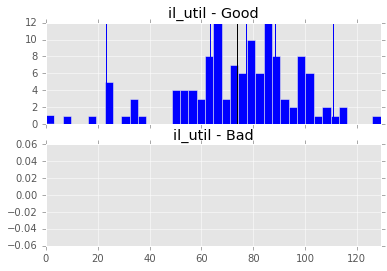

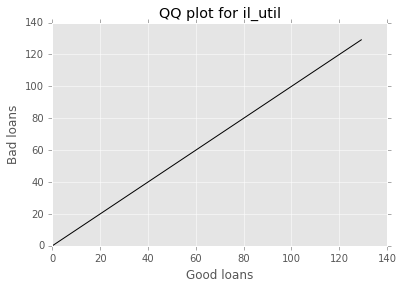

In [117]:
explore_column(lc_data, 'il_util')

* **il_util**

---------------------------
open_rv_12m: dtype=float64, 252827 nulls, count vals=8
Total number of distinct values: 8
     Total  Good  Defaults  % Defaults
1.0     39  39.0       0.0         0.0
0.0     39  39.0       0.0         0.0
2.0     31  31.0       0.0         0.0
3.0     18  18.0       0.0         0.0
5.0      8   8.0       0.0         0.0
4.0      6   6.0       0.0         0.0
7.0      2   2.0       0.0         0.0
8.0      1   1.0       0.0         0.0


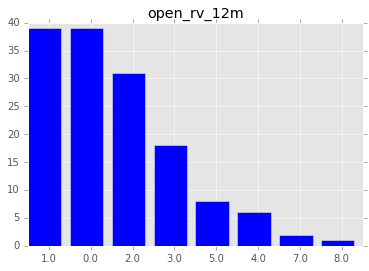

In [118]:
explore_column(lc_data, 'open_rv_12m')

* **open_rv_12m**

---------------------------
open_rv_24m: dtype=float64, 252827 nulls, count vals=14
Total number of distinct values: 14
      Total  Good  Defaults  % Defaults
2.0      29  29.0       0.0         0.0
1.0      23  23.0       0.0         0.0
4.0      19  19.0       0.0         0.0
3.0      18  18.0       0.0         0.0
5.0      15  15.0       0.0         0.0
0.0      12  12.0       0.0         0.0
6.0       9   9.0       0.0         0.0
7.0       7   7.0       0.0         0.0
9.0       5   5.0       0.0         0.0
8.0       3   3.0       0.0         0.0
21.0      1   1.0       0.0         0.0
12.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
10.0      1   1.0       0.0         0.0


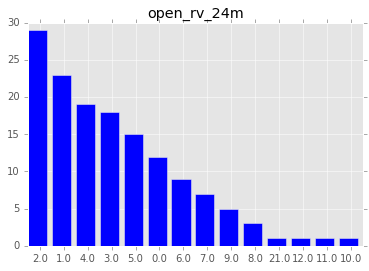

In [119]:
explore_column(lc_data, 'open_rv_24m')

* **open_rv_24m**

---------------------------
max_bal_bc: dtype=float64, 252827 nulls, count vals=139
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00     2091.25     4511.50     8212.75    16085.07    22279.00
BAD         nan         nan         nan         nan         nan         nan         nan


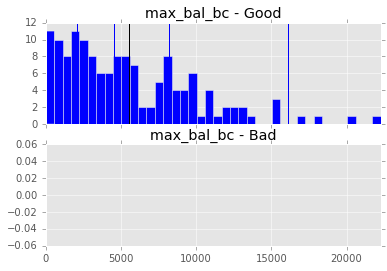

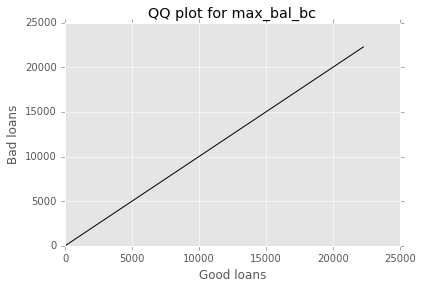

In [120]:
explore_column(lc_data, 'max_bal_bc')

* **max_bal_bc**

---------------------------
all_util: dtype=float64, 252827 nulls, count vals=126
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       7.90       18.38       46.82       61.95       74.23       91.87      102.80
BAD         nan         nan         nan         nan         nan         nan         nan


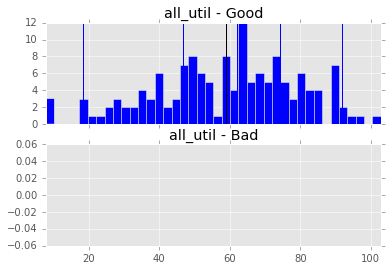

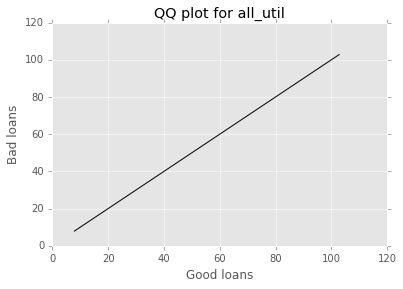

In [121]:
explore_column(lc_data, 'all_util')

* **all_util**

---------------------------
total_rev_hi_lim: dtype=float64, 63708 nulls, count vals=9543
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     4600.00    13500.00    22700.00    37800.00   101900.00  2013133.00
BAD        0.00     4000.00    12400.00    20500.00    33200.00    81330.00  1998700.00


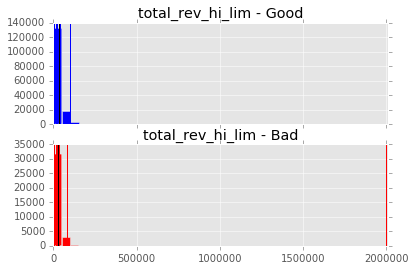

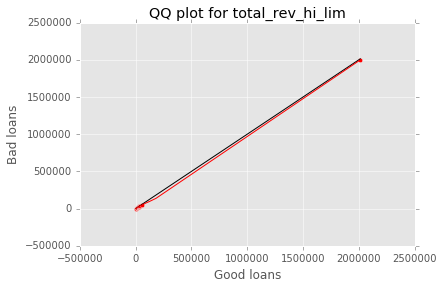

In [122]:
explore_column(lc_data, 'total_rev_hi_lim')

* **total_rev_hi_lim**

---------------------------
inq_fi: dtype=float64, 252827 nulls, count vals=9
Total number of distinct values: 9
     Total  Good  Defaults  % Defaults
0.0     62  62.0       0.0         0.0
1.0     47  47.0       0.0         0.0
2.0     12  12.0       0.0         0.0
3.0      7   7.0       0.0         0.0
4.0      5   5.0       0.0         0.0
7.0      4   4.0       0.0         0.0
5.0      4   4.0       0.0         0.0
6.0      2   2.0       0.0         0.0
9.0      1   1.0       0.0         0.0


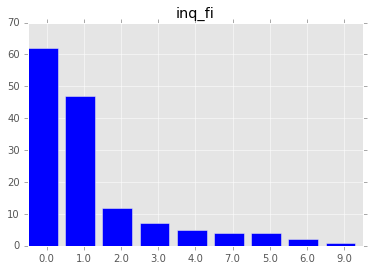

In [123]:
explore_column(lc_data, 'inq_fi')

* **inq_fi**

---------------------------
total_cu_tl: dtype=float64, 252827 nulls, count vals=18
Total number of distinct values: 18
      Total  Good  Defaults  % Defaults
0.0      78  78.0       0.0         0.0
1.0      17  17.0       0.0         0.0
2.0      16  16.0       0.0         0.0
3.0       8   8.0       0.0         0.0
4.0       5   5.0       0.0         0.0
7.0       3   3.0       0.0         0.0
12.0      3   3.0       0.0         0.0
5.0       2   2.0       0.0         0.0
6.0       2   2.0       0.0         0.0
8.0       2   2.0       0.0         0.0
18.0      1   1.0       0.0         0.0
9.0       1   1.0       0.0         0.0
10.0      1   1.0       0.0         0.0
11.0      1   1.0       0.0         0.0
13.0      1   1.0       0.0         0.0
15.0      1   1.0       0.0         0.0
17.0      1   1.0       0.0         0.0
21.0      1   1.0       0.0         0.0


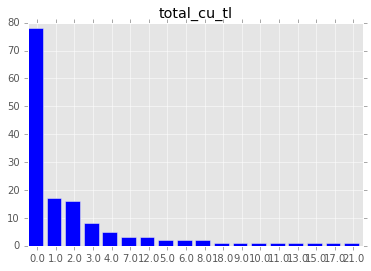

In [124]:
explore_column(lc_data, 'total_cu_tl')

* **total_cu_tl**

---------------------------
inq_last_12m: dtype=float64, 252827 nulls, count vals=17
Total number of distinct values: 17
       Total  Good  Defaults  % Defaults
 2.0      30  30.0       0.0         0.0
 1.0      25  25.0       0.0         0.0
 0.0      19  19.0       0.0         0.0
 3.0      19  19.0       0.0         0.0
-4.0      14  14.0       0.0         0.0
 6.0       8   8.0       0.0         0.0
 7.0       6   6.0       0.0         0.0
 4.0       6   6.0       0.0         0.0
 10.0      4   4.0       0.0         0.0
 5.0       4   4.0       0.0         0.0
 12.0      3   3.0       0.0         0.0
 11.0      1   1.0       0.0         0.0
 19.0      1   1.0       0.0         0.0
 13.0      1   1.0       0.0         0.0
 15.0      1   1.0       0.0         0.0
 16.0      1   1.0       0.0         0.0
 8.0       1   1.0       0.0         0.0


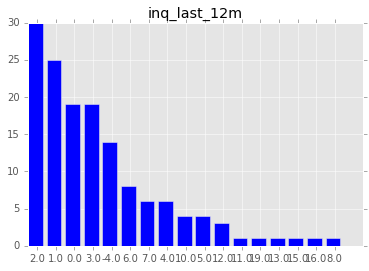

In [125]:
explore_column(lc_data, 'inq_last_12m')

* **inq_last_12m**

In [ ]:
# What can we derive from desc?
import re

def amg_clean_desc(s):
    if pd.isnull(s):
        return ''
    s = re.sub(r'Borrower added on \d+/\d+/\d+ > ', '', s)
    s = s.replace('<br>', ' ')
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    
    return s

# TODO Why does this warn?
lc_data['clean_desc'] = lc_data['desc'].apply(amg_clean_desc)
lc_data['clean_desc']

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


---------------------------
desc_len: dtype=int64, 0 nulls, count vals=2070
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00       76.00      584.00     3943.00
BAD        0.00        0.00        0.00        0.00       58.00      516.82     3853.00


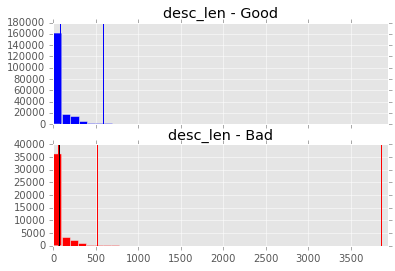

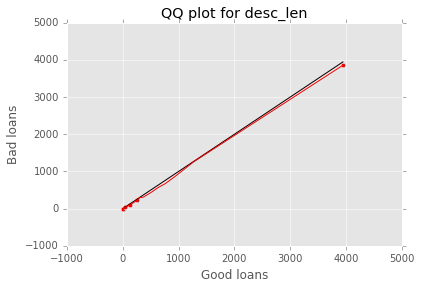

In [147]:
lc_data['desc_len'] = lc_data['clean_desc'].str.len()
explore_column(lc_data, 'desc_len')

In [154]:
sil_wordlist = set((s[:-1] for s in open('data/wordlist.txt').readlines()))

In [155]:
sil_wordlist

{'biennials',
 '',
 'reallocations',
 'jinrikishas',
 'gerontotherapy',
 'impotents',
 'localizes',
 'pawnor',
 'gemmologist',
 'chameleons',
 'clotted',
 'spiders',
 'verses',
 'hanging',
 'woody',
 'trawling',
 'comically',
 'localized',
 'spidery',
 'regularize',
 'beadsmen',
 'caner',
 'canes',
 'cycling',
 'localizer',
 'allotypic',
 'allyls',
 'caned',
 'purulently',
 'crossbar',
 'bioclimatology',
 'inviolately',
 'slothful',
 'naturopathic',
 'grenadiers',
 'trojan',
 'pigment',
 'copout',
 'potentiometers',
 'bogyman',
 'transvestism',
 'bringing',
 'bookrests',
 'wooded',
 'prissiest',
 'grueling',
 'vibrational',
 'wooden',
 'wednesday',
 'virtuosos',
 'signalizing',
 'circuitry',
 'crotch',
 'amplifications',
 'shows',
 'immunities',
 'suppressible',
 'pizzle',
 'gaskets',
 'snuggles',
 'complainers',
 'accusatorial',
 'atavic',
 'deadheads',
 'clavicular',
 'tomographies',
 'consenting',
 'hellgrammites',
 'suffixal',
 'prosody',
 'inanimate',
 'errors',
 'dialogs',
 'estr

In [162]:
def amg_misspellings(s):
    return min(30, sum([1 for w in s.lower().split()
                if len(w) > 1 and not w in sil_wordlist]))

In [163]:
lc_data['desc_misspellings_count'] = np.vectorize(amg_misspellings)(lc_data['clean_desc'])

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


---------------------------
desc_misspellings_count: dtype=int32, 0 nulls, count vals=31
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        1.00       14.00       30.00
BAD        0.00        0.00        0.00        0.00        1.00       12.00       30.00


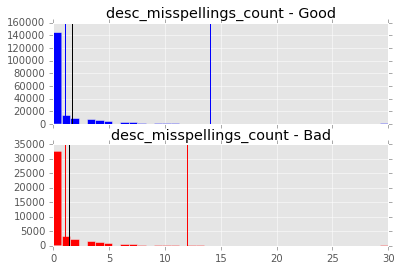

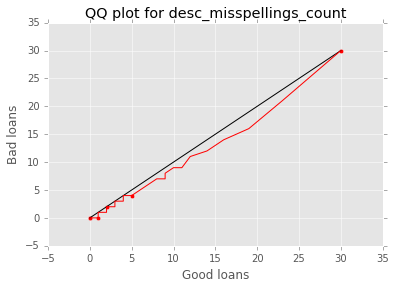

In [164]:
explore_column(lc_data, 'desc_misspellings_count')     